<a href="https://colab.research.google.com/github/muhammad-bin-nasir/FYP-Colab/blob/main/FYP_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Master paragraph at the end

<h1>7/12



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [ ]:
# ==================================================
# CUDB Preprocessing: Pre-VTAC Windows for LSTM
# ==================================================

import wfdb
import glob
import numpy as np
import os

# ------------------------------
# CONFIG
# ------------------------------
CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
WINDOW_SECONDS = 90          # input window
PREDICT_SECONDS = 60         # prediction horizon
FS = 250                     # CUDB sampling rate (Hz)
WINDOW_SAMPLES = WINDOW_SECONDS * FS
PREDICT_SAMPLES = PREDICT_SECONDS * FS

records = sorted(glob.glob(os.path.join(CUDB_PATH, "*.dat")))
print(f"Found {len(records)} CUDB records\n")

# ------------------------------
# Helper: map annotation symbol to rhythm
# ------------------------------
def classify_symbol(symbol):
    """Map CUDB annotation symbols to rhythm types"""
    if symbol == '[':
        return "VT_START"
    if symbol == ']':
        return "VT_END"
    if symbol == '+':
        return "VFIB"
    return "NORMAL"

# ------------------------------
# Preprocess each record
# ------------------------------
all_windows = []  # store (ECG_window, time_to_VTAC) tuples

for rec_path in records:
    rec_name = os.path.basename(rec_path).replace(".dat", "")
    print(f"Processing {rec_name} ...")

    # Load ECG
    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        sig = record.p_signal[:,0]  # single lead
        sig_len = len(sig)
    except Exception as e:
        print(f"  ERROR reading record: {e}")
        continue

    # Load annotation
    ann = None
    for ext in ["atr","tr"]:
        try:
            ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), ext)
            break
        except:
            ann = None
    if ann is None:
        print(f"  No annotation found for {rec_name}")
        continue

    ann_samples = ann.sample
    ann_symbols = ann.symbol

    # Find VTAC start indices
    vt_starts = [s for s, sym in zip(ann_samples, ann_symbols) if sym == '[']
    if len(vt_starts) == 0:
        print(f"  No VTAC start found in {rec_name}, skipping")
        continue
    vt_start_sample = vt_starts[0]  # only first VTAC per record

    # ------------------------------
    # Generate pre-VTAC windows
    # ------------------------------
    start_idx = 0
    while (start_idx + WINDOW_SAMPLES + PREDICT_SAMPLES) <= vt_start_sample:
        window_sig = sig[start_idx : start_idx + WINDOW_SAMPLES]
        # compute time-to-VTAC in seconds
        window_end = start_idx + WINDOW_SAMPLES
        time_to_vt = (vt_start_sample - window_end) / FS
        all_windows.append((window_sig, time_to_vt))
        start_idx += FS  # stride 1 second

    print(f"  Created {len(all_windows)} windows so far")

print(f"\nTotal pre-VTAC windows collected: {len(all_windows)}")

# ------------------------------
# Convert to numpy arrays and save (optional)
# ------------------------------
X = np.array([w[0] for w in all_windows])
y = np.array([w[1] for w in all_windows])
print("X shape:", X.shape)
print("y shape:", y.shape)

# Example: save to Drive
np.save(os.path.join(CUDB_PATH, "CUDB_preVTAC_X.npy"), X)
np.save(os.path.join(CUDB_PATH, "CUDB_preVTAC_y.npy"), y)

print("\nPreprocessing complete. Arrays saved to Drive.")


Found 35 CUDB records

Processing cu01 ...
  Created 65 windows so far
Processing cu02 ...
  No VTAC start found in cu02, skipping
Processing cu03 ...
  Created 381 windows so far
Processing cu04 ...
  Created 387 windows so far
Processing cu05 ...
  Created 596 windows so far
Processing cu06 ...
  Created 631 windows so far
Processing cu07 ...
  Created 664 windows so far
Processing cu08 ...
  Created 941 windows so far
Processing cu09 ...
  Created 1031 windows so far
Processing cu10 ...
  Created 1198 windows so far
Processing cu11 ...
  Created 1420 windows so far
Processing cu12 ...
  Created 1532 windows so far
Processing cu13 ...
  Created 1810 windows so far
Processing cu14 ...
  No VTAC start found in cu14, skipping
Processing cu15 ...
  Created 2066 windows so far
Processing cu16 ...
  Created 2171 windows so far
Processing cu17 ...
  Created 2404 windows so far
Processing cu18 ...
  Created 2589 windows so far
Processing cu19 ...
  Created 2849 windows so far
Processing cu20

KeyboardInterrupt: 

In this step, we will download the Normal Sinus Rhythm (NSR) dataset from PhysioNet, which contains ECG recordings of healthy individuals. This dataset will serve as the baseline normal ECG for training our LSTM next-step predictor. The model will learn the typical patterns of normal heart rhythms from these recordings. Later, during inference on CUDB data, the model will use this knowledge to ignore normal ECG segments and only highlight anomalous windows preceding VTAC events, allowing us to detect pre-VTAC patterns effectively.

In [ ]:
# In Colab: Mount your Google Drive, then download NSRDB into a folder in Drive.

from google.colab import drive
drive.mount('/content/drive')

# change this path if you want a different folder
output_dir = '/content/drive/MyDrive/nsrdb/'

!pip install wfdb --quiet

import wfdb
import os

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Download whole database
wfdb.dl_database('nsrdb', output_dir, records='all', annotators='all', keep_subdirs=True, overwrite=False)

print("Download complete. Files are under:", output_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generating record list for: 16265
Generating record list for: 16272
Generating record list for: 16273
Generating record list for: 16420
Generating record list for: 16483
Generating record list for: 16539
Generating record list for: 16773
Generating record list for: 16786
Generating record list for: 16795
Generating record list for: 17052
Generating record list for: 17453
Generating record list for: 18177
Generating record list for: 18184
Generating record list for: 19088
Generating record list for: 19090
Generating record list for: 19093
Generating record list for: 19140
Generating record list for: 19830
Generating list of all files for: 16265
Generating list of all files for: 16272
Generating list of all files for: 16273
Generating list of all files for: 16420
Generating list of all files for: 16483
Generating list of all files for: 16539
Generating list of 

<h1>Older autoencoder taking 150 second windows

Conversion of nsrdb into NPY files.

In [ ]:
import wfdb
import numpy as np
import os

NSR_PATH = "/content/drive/MyDrive/nsrdb/"
OUTPUT_DIR = "/content/drive/MyDrive/Models/NSR_windows_small/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

nsr_records = [
    "16272","19830","16539","16773","16786","16265","16420","17453",
    "17052","16483","19140","19093","16273","18184","18177","19088",
    "16795","19090"
]

FS = 250
WINDOW_SEC = 150
WINDOW_SIZE = FS * WINDOW_SEC

saved_files = []

print("Extracting first 150 seconds from each NSR record...\n")

for rec_name in nsr_records:
    try:
        record_path = os.path.join(NSR_PATH, rec_name)
        record = wfdb.rdrecord(record_path)
        ecg = record.p_signal[:, 0]  # MLII lead
    except Exception as e:
        print(f"Error loading {rec_name}: {e}")
        continue

    if len(ecg) < WINDOW_SIZE:
        print(f"Skipping {rec_name}: ECG too short.")
        continue

    # Take FIRST 150 seconds only
    window = ecg[:WINDOW_SIZE].astype(np.float32)

    out_file = os.path.join(OUTPUT_DIR, f"X_nsr_{rec_name}.npy")
    np.save(out_file, window)
    saved_files.append(out_file)

    print(f"Saved 1 window for {rec_name} → {out_file}")

# Step 2: Concatenate all windows into a single array
print("\nConcatenating all NSR windows...")

all_data = []
for f in saved_files:
    all_data.append(np.load(f))

# Final shape → (num_records, 22500)
X_final = np.stack(all_data, axis=0)

final_file = os.path.join(OUTPUT_DIR, "X_nsr_final.npy")
np.save(final_file, X_final)

print(f"Final NSR dataset saved: {final_file}")
print(f"Final shape: {X_final.shape}")


Extracting first 90 seconds from each NSR record...

Saved 1 window for 16272 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16272.npy
Saved 1 window for 19830 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_19830.npy
Saved 1 window for 16539 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16539.npy
Saved 1 window for 16773 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16773.npy
Saved 1 window for 16786 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16786.npy
Saved 1 window for 16265 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16265.npy
Saved 1 window for 16420 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16420.npy
Saved 1 window for 17453 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_17453.npy
Saved 1 window for 17052 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_17052.npy
Saved 1 window for 16483 → /content/drive/MyDrive/Models/NSR_windows_small/X_nsr_16483.npy
Saved 1 window for 19140 → /content/d

LSTM Autoencoder training on normal ECG

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

# --- Hyperparameters ---
SEQ_LEN = 150 * 250        # 150 seconds × 250 Hz
HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 2             # Small batch size due to long sequences
EPOCHS = 20
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset ---
class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # For autoencoder, input == target
        return self.X[idx][:, np.newaxis], self.X[idx][:, np.newaxis]

# --- LSTM Autoencoder ---
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        # Encoder
        enc_out, (h, c) = self.encoder(x)
        # Decoder
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# --- Load NSR windows ---
X_nsr = np.load("/content/drive/MyDrive/Models/NSR_windows_small/X_nsr_final.npy")
dataset = ECGDataset(X_nsr)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Initialize model, loss, optimizer ---
model = LSTMAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# --- Training loop ---
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.6f}")

# --- Save trained model ---
MODEL_DIR = "/content/drive/MyDrive/Models/NSR/"
os.makedirs(MODEL_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "LSTM_NSR_autoencoder.pth"))
print("NSR LSTM autoencoder trained and saved successfully.")


Epoch 1/20, Loss: 0.214424
Epoch 2/20, Loss: 0.198809
Epoch 3/20, Loss: 0.195857
Epoch 4/20, Loss: 0.193262
Epoch 5/20, Loss: 0.190715
Epoch 6/20, Loss: 0.188204
Epoch 7/20, Loss: 0.185732
Epoch 8/20, Loss: 0.183238
Epoch 9/20, Loss: 0.180723
Epoch 10/20, Loss: 0.178192
Epoch 11/20, Loss: 0.175629
Epoch 12/20, Loss: 0.173043
Epoch 13/20, Loss: 0.170352
Epoch 14/20, Loss: 0.167667
Epoch 15/20, Loss: 0.164939
Epoch 16/20, Loss: 0.162244
Epoch 17/20, Loss: 0.159596
Epoch 18/20, Loss: 0.157047
Epoch 19/20, Loss: 0.154673
Epoch 20/20, Loss: 0.152493
NSR LSTM autoencoder trained and saved successfully.


Running the model on the first file for the determination of hyperparameters to detect the abnormal ECG by setting a threshold of Errors.


In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
import json
from tqdm import tqdm
import pandas as pd

# --- Hyperparameters ---
SEQ_LEN = 150 * 250      # 150 seconds
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths ---
CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder.pth"
ERRORS_CSV = "/content/drive/MyDrive/Models/Threshold_Exploration.csv"

CHECKPOINT_PATH = "/content/drive/MyDrive/Models/threshold_checkpoint.json"

# --- LSTM Autoencoder ---
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# --- Load model ---
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# --- Reconstruction error ---
def reconstruction_error(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(-1)
        recon = model(x_tensor)
        return ((recon.squeeze(-1) - x_tensor.squeeze(-1)) ** 2).mean().item()

# --- Pick first record only ---
records = sorted([f[:-4] for f in os.listdir(CUDB_PATH) if f.endswith(".hea")])
rec_name = records[0]
print(f"Using sample record: {rec_name}")

# --- Load ECG ---
record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ecg = record.p_signal[:, 0]

total_windows = len(ecg) - SEQ_LEN + 1


# --- Load checkpoint if exists ---
if os.path.exists(CHECKPOINT_PATH):
    print("\nCheckpoint found. Resuming...\n")
    with open(CHECKPOINT_PATH, "r") as f:
        ckpt = json.load(f)

    start_idx = ckpt["last_index"] + 1
    errors = ckpt["errors"]
else:
    print("\nNo checkpoint found. Starting fresh...\n")
    start_idx = 0
    errors = []


# --- Calculate percent steps ---
percent_step = max(1, total_windows // 20)   # 5 percent increments


print("Processing windows...\n")

for idx in tqdm(range(start_idx, total_windows)):

    window = ecg[idx:idx + SEQ_LEN].astype(np.float32)
    err = reconstruction_error(window)
    errors.append(err)

    # Save checkpoint every 5 percent progress
    if idx % percent_step == 0:
        ckpt_data = {
            "last_index": idx,
            "errors": errors,
            "total_windows": total_windows,
            "record": rec_name
        }
        with open(CHECKPOINT_PATH, "w") as f:
            json.dump(ckpt_data, f)
        print(f"\nCheckpoint saved at index {idx} ({(idx/total_windows)*100:.1f} percent)\n")


# --- Final save ---
df = pd.DataFrame({"error": errors})
df.to_csv(ERRORS_CSV, index=False)

# Remove checkpoint so resumed runs don’t restart from old data
if os.path.exists(CHECKPOINT_PATH):
    os.remove(CHECKPOINT_PATH)

print(f"\nSaved {len(errors)} window errors to {ERRORS_CSV}")

# --- Stats ---
print("\n=== Reconstruction Error Statistics ===")
print(f"Min:     {df.error.min():.6f}")
print(f"Max:     {df.error.max():.6f}")
print(f"Median:  {df.error.median():.6f}")
print(f"95th:    {df.error.quantile(0.95):.6f}")
print(f"98th:    {df.error.quantile(0.98):.6f}")
print(f"99th:    {df.error.quantile(0.99):.6f}")

print("\nDone without crashing. Enjoy.")


Using sample record: cu01

Checkpoint found. Resuming...

Processing windows...



 50%|████▉     | 4486/8984 [16:12<18:23,  4.07it/s]


Checkpoint saved at index 85234 (95.0 percent)



100%|█████████▉| 8972/8984 [32:24<00:02,  4.04it/s]


Checkpoint saved at index 89720 (100.0 percent)



100%|██████████| 8984/8984 [32:27<00:00,  4.61it/s]


Saved 89733 window errors to /content/drive/MyDrive/Models/Threshold_Exploration.csv

=== Reconstruction Error Statistics ===
Min:     0.180769
Max:     0.379648
Median:  0.293035
95th:    0.377300
98th:    0.377786
99th:    0.378853

Done without crashing. Enjoy.


<h1>Newer autoencoder with 10 second window

nsrdb formation

In [ ]:
import wfdb
import numpy as np
import os

NSR_PATH = "/content/drive/MyDrive/nsrdb/"
OUTPUT_DIR = "/content/drive/MyDrive/Models/nsr_100s/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

nsr_records = [
    "16272","19830","16539","16773","16786","16265","16420","17453",
    "17052","16483","19140","19093","16273","18184","18177","19088",
    "16795","19090"
]

FS = 250
WINDOW_SEC = 100
WINDOW_SIZE = FS * WINDOW_SEC

saved_files = []

print("Extracting first 100 seconds from each NSR record...\n")

for rec_name in nsr_records:
    try:
        record_path = os.path.join(NSR_PATH, rec_name)
        record = wfdb.rdrecord(record_path)
        ecg = record.p_signal[:, 0]  # MLII lead
    except Exception as e:
        print(f"Error loading {rec_name}: {e}")
        continue

    if len(ecg) < WINDOW_SIZE:
        print(f"Skipping {rec_name}: ECG too short.")
        continue

    # Take FIRST 100 seconds only
    window = ecg[:WINDOW_SIZE].astype(np.float32)

    out_file = os.path.join(OUTPUT_DIR, f"X_nsr_{rec_name}.npy")
    np.save(out_file, window)
    saved_files.append(out_file)

    print(f"Saved 1 window for {rec_name} → {out_file}")

# Step 2: Concatenate all windows into a single array
print("\nConcatenating all NSR windows...")

all_data = []
for f in saved_files:
    all_data.append(np.load(f))

# Final shape → (num_records, 22500)
X_final = np.stack(all_data, axis=0)

final_file = os.path.join(OUTPUT_DIR, "X_nsr_final.npy")
np.save(final_file, X_final)

print(f"Final NSR dataset saved: {final_file}")
print(f"Final shape: {X_final.shape}")


Extracting first 10 seconds from each NSR record...

Saved 1 window for 16272 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16272.npy
Saved 1 window for 19830 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_19830.npy
Saved 1 window for 16539 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16539.npy
Saved 1 window for 16773 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16773.npy
Saved 1 window for 16786 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16786.npy
Saved 1 window for 16265 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16265.npy
Saved 1 window for 16420 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16420.npy
Saved 1 window for 17453 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_17453.npy
Saved 1 window for 17052 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_17052.npy
Saved 1 window for 16483 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_16483.npy
Saved 1 window for 19140 → /content/drive/MyDrive/Models/nsr_100s/X_nsr_19140.npy
Saved 1 window for 19093 → /content/drive/MyD

Training autoencoder

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

# ------------------ Hyperparameters ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS

HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 32          # Now possible because sequences are shorter
EPOCHS = 30
LR = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------ Dataset ------------------
class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx][:, None]
        return x, x

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load NSR Windows ------------------
X_nsr = np.load("/content/drive/MyDrive/Models/nsr_100s/X_nsr_final.npy")

dataset = ECGDataset(X_nsr)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# ------------------ Training Setup ------------------
model = LSTMAutoencoder().to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# ------------------ Training Loop ------------------
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f}")

# ------------------ Save Model ------------------
MODEL_DIR = "/content/drive/MyDrive/Models/NSR/"
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save(
    model.state_dict(),
    os.path.join(MODEL_DIR, "LSTM_NSR_autoencoder_10s.pth")
)

print("10 second NSR LSTM autoencoder trained and saved.")


Epoch 1/30 | Loss: 0.544702
Epoch 2/30 | Loss: 0.394604
Epoch 3/30 | Loss: 0.263594
Epoch 4/30 | Loss: 0.179080
Epoch 5/30 | Loss: 0.143273
Epoch 6/30 | Loss: 0.138603
Epoch 7/30 | Loss: 0.144896
Epoch 8/30 | Loss: 0.150907
Epoch 9/30 | Loss: 0.154313
Epoch 10/30 | Loss: 0.155710
Epoch 11/30 | Loss: 0.155729
Epoch 12/30 | Loss: 0.154678
Epoch 13/30 | Loss: 0.152659
Epoch 14/30 | Loss: 0.149690
Epoch 15/30 | Loss: 0.145828
Epoch 16/30 | Loss: 0.141420
Epoch 17/30 | Loss: 0.137753
Epoch 18/30 | Loss: 0.138075
Epoch 19/30 | Loss: 0.142776
Epoch 20/30 | Loss: 0.141697
Epoch 21/30 | Loss: 0.137408
Epoch 22/30 | Loss: 0.135102
Epoch 23/30 | Loss: 0.134796
Epoch 24/30 | Loss: 0.135178
Epoch 25/30 | Loss: 0.135464
Epoch 26/30 | Loss: 0.135354
Epoch 27/30 | Loss: 0.134789
Epoch 28/30 | Loss: 0.133821
Epoch 29/30 | Loss: 0.132577
Epoch 30/30 | Loss: 0.131251
10 second NSR LSTM autoencoder trained and saved.


Computing errors and compare:

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250                       # Sampling frequency (Hz)
SEQ_LEN_SEC = 10              # Window length in seconds
SEQ_LEN = SEQ_LEN_SEC * FS     # Window length in samples
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Load First CUDB Record ------------------
records = sorted([f[:-4] for f in os.listdir(CUDB_PATH) if f.endswith(".hea")])
rec_name = records[0]

print(f"\nUsing sample CUDB record: {rec_name}")

record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
ecg = record.p_signal[:, 0]

# ------------------ Find VTAC Start ------------------
vt_start_sample = None
for sym, samp in zip(ann.symbol, ann.sample):
    if sym == '[':
        vt_start_sample = samp
        break

if vt_start_sample is None:
    raise RuntimeError("No VTAC '[' annotation found in this record")

vt_start_second = vt_start_sample // FS

print(f"VTAC starts at sample: {vt_start_sample}")
print(f"VTAC starts at second: {vt_start_second}")

# ------------------ Define Analysis Region (SECONDS) ------------------
NORMAL_SEC_BEFORE = 210
VT_SEC_AFTER = 100

normal_seconds = list(range(vt_start_second - NORMAL_SEC_BEFORE, vt_start_second,5))
vt_seconds = list(range(vt_start_second, vt_start_second + VT_SEC_AFTER))

errors_normal = []
errors_vt = []

print("\nComputing reconstruction errors (1 window per second)...\n")

# ------------------ Normal Windows ------------------
for sec in normal_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if start_sample < 0 or end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_normal.append(err)

# ------------------ VTAC Windows ------------------
for sec in vt_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_vt.append(err)

# ------------------ Print Comparison ------------------
print("\n=== Reconstruction Error Comparison (SECONDS BASED) ===\n")

print("Normal rhythm windows (Every 5th second from the start of sample):")
for i, e in enumerate(errors_normal):
    print(f"Normal sec {(5*i)+1:02d}: {e:.6f}")

print("\nVTAC windows (100 seconds AFTER VTAC onset):")
for i, e in enumerate(errors_vt):
    print(f"VTAC sec {i+1:02d}: {e:.6f}")

print("\n--- Summary Statistics ---")
print(f"Normal mean: {np.mean(errors_normal):.6f}")
print(f"Normal max:  {np.max(errors_normal):.6f}")
print(f"VTAC mean:   {np.mean(errors_vt):.6f}")
print(f"VTAC min:    {np.min(errors_vt):.6f}")

gap = np.min(errors_vt) - np.max(errors_normal)
print(f"\nSeparation gap (VTAC min − Normal max): {gap:.6f}")



Using sample CUDB record: cu01
VTAC starts at sample: 53546
VTAC starts at second: 214

Computing reconstruction errors (1 window per second)...


=== Reconstruction Error Comparison (SECONDS BASED) ===

Normal rhythm windows (Every 5th second from the start of sample):
Normal sec 01: 0.110882
Normal sec 06: 0.113646
Normal sec 11: 0.121762
Normal sec 16: 0.110831
Normal sec 21: 0.109084
Normal sec 26: 0.124548
Normal sec 31: 0.142751
Normal sec 36: 0.141155
Normal sec 41: 0.117428
Normal sec 46: 0.113749
Normal sec 51: 0.123342
Normal sec 56: 0.134570
Normal sec 61: 0.135457
Normal sec 66: 0.136573
Normal sec 71: 0.155528
Normal sec 76: 0.142900
Normal sec 81: 0.104496
Normal sec 86: 0.107985
Normal sec 91: 0.123310
Normal sec 96: 0.131477
Normal sec 101: 0.135297
Normal sec 106: 0.124795
Normal sec 111: 0.124332
Normal sec 116: 0.126150
Normal sec 121: 0.196156
Normal sec 126: 0.702925
Normal sec 131: 0.690753
Normal sec 136: 0.165053
Normal sec 141: 0.099636
Normal sec 146: 0.11278

Same code but for cu02

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250                       # Sampling frequency (Hz)
SEQ_LEN_SEC = 10              # Window length in seconds
SEQ_LEN = SEQ_LEN_SEC * FS     # Window length in samples
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Load First CUDB Record ------------------
records = sorted([f[:-4] for f in os.listdir(CUDB_PATH) if f.endswith(".hea")])
rec_name = records[2]

print(f"\nUsing sample CUDB record: {rec_name}")

record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
ecg = record.p_signal[:, 0]

# ------------------ Find VTAC Start ------------------
vt_start_sample = None
for sym, samp in zip(ann.symbol, ann.sample):
    if sym == '[':
        vt_start_sample = samp
        break

if vt_start_sample is None:
    raise RuntimeError("No VTAC '[' annotation found in this record")

vt_start_second = vt_start_sample // FS

print(f"VTAC starts at sample: {vt_start_sample}")
print(f"VTAC starts at second: {vt_start_second}")

# ------------------ Define Analysis Region (SECONDS) ------------------
NORMAL_SEC_BEFORE = 450
VT_SEC_AFTER = 100

normal_seconds = list(range(vt_start_second - NORMAL_SEC_BEFORE, vt_start_second,5))
vt_seconds = list(range(vt_start_second, vt_start_second + VT_SEC_AFTER))

errors_normal = []
errors_vt = []

print("\nComputing reconstruction errors (1 window per second)...\n")

# ------------------ Normal Windows ------------------
for sec in normal_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if start_sample < 0 or end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_normal.append(err)

# ------------------ VTAC Windows ------------------
for sec in vt_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    print(f"sec={sec}, min={window.min()}, max={window.max()}, nan={np.isnan(window).any()}, inf={np.isinf(window).any()}")
    err = reconstruction_error(window)
    errors_vt.append(err)

# ------------------ Print Comparison ------------------
print("\n=== Reconstruction Error Comparison (SECONDS BASED) ===\n")

print("Normal rhythm windows (Every 5th second from the start of sample):")
for i, e in enumerate(errors_normal):
    print(f"Normal sec {(5*i)+1+vt_start_second - NORMAL_SEC_BEFORE:02d}: {e:.6f}")

print("\nVTAC windows (100 seconds AFTER VTAC onset):")
for i, e in enumerate(errors_vt):
    print(f"VTAC sec {i+1:02d}: {e:.6f}")

print("\n--- Summary Statistics ---")
print(f"Normal mean: {np.mean(errors_normal):.6f}")
print(f"Normal max:  {np.max(errors_normal):.6f}")
print(f"VTAC mean:   {np.mean(errors_vt):.6f}")
print(f"VTAC min:    {np.min(errors_vt):.6f}")

gap = np.min(errors_vt) - np.max(errors_normal)
print(f"\nSeparation gap (VTAC min − Normal max): {gap:.6f}")



Using sample CUDB record: cu03
VTAC starts at sample: 116431
VTAC starts at second: 465

Computing reconstruction errors (1 window per second)...

sec=465, min=-1.7300000190734863, max=1.8600000143051147, nan=False, inf=False
sec=466, min=-1.7300000190734863, max=1.5700000524520874, nan=False, inf=False
sec=467, min=-1.7200000286102295, max=1.5700000524520874, nan=False, inf=False
sec=468, min=nan, max=nan, nan=True, inf=False
sec=469, min=nan, max=nan, nan=True, inf=False
sec=470, min=nan, max=nan, nan=True, inf=False
sec=471, min=nan, max=nan, nan=True, inf=False
sec=472, min=nan, max=nan, nan=True, inf=False
sec=473, min=nan, max=nan, nan=True, inf=False
sec=474, min=nan, max=nan, nan=True, inf=False
sec=475, min=nan, max=nan, nan=True, inf=False
sec=476, min=nan, max=nan, nan=True, inf=False
sec=477, min=nan, max=nan, nan=True, inf=False
sec=478, min=-0.625, max=1.684999942779541, nan=False, inf=False
sec=479, min=-0.625, max=1.684999942779541, nan=False, inf=False
sec=480, min=-0

CU04

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250                       # Sampling frequency (Hz)
SEQ_LEN_SEC = 10              # Window length in seconds
SEQ_LEN = SEQ_LEN_SEC * FS     # Window length in samples
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Load First CUDB Record ------------------
records = sorted([f[:-4] for f in os.listdir(CUDB_PATH) if f.endswith(".hea")])
rec_name = records[3]

print(f"\nUsing sample CUDB record: {rec_name}")

record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
ecg = record.p_signal[:, 0]

# ------------------ Find VTAC Start ------------------
vt_start_sample = None
for sym, samp in zip(ann.symbol, ann.sample):
    if sym == '[':
        vt_start_sample = samp
        break

if vt_start_sample is None:
    raise RuntimeError("No VTAC '[' annotation found in this record")

vt_start_second = vt_start_sample // FS

print(f"VTAC starts at sample: {vt_start_sample}")
print(f"VTAC starts at second: {vt_start_second}")

# ------------------ Define Analysis Region (SECONDS) ------------------
NORMAL_SEC_BEFORE = 140
VT_SEC_AFTER = 100

normal_seconds = list(range(vt_start_second - NORMAL_SEC_BEFORE, vt_start_second,5))
vt_seconds = list(range(vt_start_second, vt_start_second + VT_SEC_AFTER))

errors_normal = []
errors_vt = []

print("\nComputing reconstruction errors (1 window per second)...\n")

# ------------------ Normal Windows ------------------
for sec in normal_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if start_sample < 0 or end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_normal.append(err)

# ------------------ VTAC Windows ------------------
for sec in vt_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_vt.append(err)

# ------------------ Print Comparison ------------------
print("\n=== Reconstruction Error Comparison (SECONDS BASED) ===\n")

print("Normal rhythm windows (Every 5th second from the start of sample):")
for i, e in enumerate(errors_normal):
    print(f"Normal sec {(5*i)+1+vt_start_second - NORMAL_SEC_BEFORE:02d}: {e:.6f}")

print("\nVTAC windows (100 seconds AFTER VTAC onset):")
for i, e in enumerate(errors_vt):
    print(f"VTAC sec {i+1:02d}: {e:.6f}")

print("\n--- Summary Statistics ---")
print(f"Normal mean: {np.mean(errors_normal):.6f}")
print(f"Normal max:  {np.max(errors_normal):.6f}")
print(f"VTAC mean:   {np.mean(errors_vt):.6f}")
print(f"VTAC min:    {np.min(errors_vt):.6f}")

gap = np.min(errors_vt) - np.max(errors_normal)
print(f"\nSeparation gap (VTAC min − Normal max): {gap:.6f}")



Using sample CUDB record: cu04
VTAC starts at sample: 38828
VTAC starts at second: 155

Computing reconstruction errors (1 window per second)...


=== Reconstruction Error Comparison (SECONDS BASED) ===

Normal rhythm windows (Every 5th second from the start of sample):
Normal sec 16: 0.084469
Normal sec 21: 0.090454
Normal sec 26: 0.087101
Normal sec 31: 0.106273
Normal sec 36: 0.105585
Normal sec 41: 0.090373
Normal sec 46: 0.091751
Normal sec 51: 0.091928
Normal sec 56: 0.090845
Normal sec 61: 0.079052
Normal sec 66: 0.067533
Normal sec 71: 0.080302
Normal sec 76: 0.089481
Normal sec 81: 0.073398
Normal sec 86: 0.078411
Normal sec 91: 0.079195
Normal sec 96: 0.080681
Normal sec 101: 0.079059
Normal sec 106: 0.087641
Normal sec 111: 0.090708
Normal sec 116: 0.075922
Normal sec 121: 0.111050
Normal sec 126: 0.110641
Normal sec 131: 0.120729
Normal sec 136: 0.146187
Normal sec 141: 0.176892
Normal sec 146: 0.254189
Normal sec 151: 0.170705

VTAC windows (100 seconds AFTER VTAC onset):

CU05

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250                       # Sampling frequency (Hz)
SEQ_LEN_SEC = 10              # Window length in seconds
SEQ_LEN = SEQ_LEN_SEC * FS     # Window length in samples
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)  # (1, T, 1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Load First CUDB Record ------------------
records = sorted([f[:-4] for f in os.listdir(CUDB_PATH) if f.endswith(".hea")])
rec_name = records[4]

print(f"\nUsing sample CUDB record: {rec_name}")

record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
ecg = record.p_signal[:, 0]

# ------------------ Find VTAC Start ------------------
vt_start_sample = None
for sym, samp in zip(ann.symbol, ann.sample):
    if sym == '[':
        vt_start_sample = samp
        break

if vt_start_sample is None:
    raise RuntimeError("No VTAC '[' annotation found in this record")

vt_start_second = vt_start_sample // FS

print(f"VTAC starts at sample: {vt_start_sample}")
print(f"VTAC starts at second: {vt_start_second}")

# ------------------ Define Analysis Region (SECONDS) ------------------
NORMAL_SEC_BEFORE = 340
VT_SEC_AFTER = 100

normal_seconds = list(range(vt_start_second - NORMAL_SEC_BEFORE, vt_start_second,5))
vt_seconds = list(range(vt_start_second, vt_start_second + VT_SEC_AFTER))

errors_normal = []
errors_vt = []

print("\nComputing reconstruction errors (1 window per second)...\n")

# ------------------ Normal Windows ------------------
for sec in normal_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if start_sample < 0 or end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_normal.append(err)

# ------------------ VTAC Windows ------------------
for sec in vt_seconds:
    start_sample = sec * FS
    end_sample = start_sample + SEQ_LEN

    if end_sample > len(ecg):
        continue

    window = ecg[start_sample:end_sample].astype(np.float32)
    err = reconstruction_error(window)
    errors_vt.append(err)

# ------------------ Print Comparison ------------------
print("\n=== Reconstruction Error Comparison (SECONDS BASED) ===\n")

print("Normal rhythm windows (Every 5th second from the start of sample):")
for i, e in enumerate(errors_normal):
    print(f"Normal sec {(5*i)+1+vt_start_second - NORMAL_SEC_BEFORE:02d}: {e:.6f}")

print("\nVTAC windows (100 seconds AFTER VTAC onset):")
for i, e in enumerate(errors_vt):
    print(f"VTAC sec {i+1:02d}: {e:.6f}")

print("\n--- Summary Statistics ---")
print(f"Normal mean: {np.mean(errors_normal):.6f}")
print(f"Normal max:  {np.max(errors_normal):.6f}")
print(f"VTAC mean:   {np.mean(errors_vt):.6f}")
print(f"VTAC min:    {np.min(errors_vt):.6f}")

gap = np.min(errors_vt) - np.max(errors_normal)
print(f"\nSeparation gap (VTAC min − Normal max): {gap:.6f}")



Using sample CUDB record: cu05
VTAC starts at sample: 89692
VTAC starts at second: 358

Computing reconstruction errors (1 window per second)...


=== Reconstruction Error Comparison (SECONDS BASED) ===

Normal rhythm windows (Every 5th second from the start of sample):
Normal sec 19: 0.173416
Normal sec 24: 0.178039
Normal sec 29: 0.283933
Normal sec 34: 0.280233
Normal sec 39: 0.229333
Normal sec 44: 0.246109
Normal sec 49: 0.225213
Normal sec 54: 0.200392
Normal sec 59: 0.201146
Normal sec 64: 0.186454
Normal sec 69: 0.195518
Normal sec 74: 0.192837
Normal sec 79: 0.258187
Normal sec 84: 0.774505
Normal sec 89: 0.739374
Normal sec 94: 0.238098
Normal sec 99: 0.160245
Normal sec 104: 0.151998
Normal sec 109: 0.152446
Normal sec 114: 0.191862
Normal sec 119: 0.212021
Normal sec 124: 0.178774
Normal sec 129: 0.255104
Normal sec 134: 0.277484
Normal sec 139: 0.808593
Normal sec 144: 0.882127
Normal sec 149: 0.304647
Normal sec 154: 0.227879
Normal sec 159: 0.176788
Normal sec 164: 0.15

<h1>16/12

Actual test For all CUDB files

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Predict Abnormal Segments ------------------
def predict_abnormal(ecg, fs=FS, seq_len=SEQ_LEN, threshold=ERROR_THRESHOLD, consecutive=CONSECUTIVE_SEC):
    errors = []
    n_samples = len(ecg)
    n_seconds = n_samples // fs

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * fs
        end = start + seq_len
        if end > n_samples:
            break
        window = ecg[start:end].astype(np.float32)
        err = reconstruction_error(window)
        errors.append(err)

    errors = np.array(errors)
    predictions = np.zeros_like(errors, dtype=int)

    for i in range(len(errors) - consecutive + 1):
        if np.all(errors[i:i+consecutive] > threshold):
            predictions[i:i+consecutive] = 1

    return errors, predictions

# ==================================================
#                BATCH EXECUTION
# ==================================================

summary = []

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"
    print(f"\n==============================")
    print(f"Processing CUDB record: {rec_name}")
    print(f"==============================")

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        print("Failed to load record or annotation")
        continue

    # ---------- Annotations ----------
    vtac_annot_sec = None
    vfib_annot_sec = None

    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[' and vtac_annot_sec is None:
            vtac_annot_sec = samp // FS
        if sym == '+' and vfib_annot_sec is None:
            vfib_annot_sec = samp // FS

    if vtac_annot_sec is not None:
        print(f"Annotated VTAC start time: {vtac_annot_sec} seconds")
    else:
        print("No VTAC annotation found")

    if vfib_annot_sec is not None:
        print(f"Annotated VFIB start time: {vfib_annot_sec} seconds")
    else:
        print("No VFIB annotation found")

    # ---------- Model Prediction ----------
    errors, predictions = predict_abnormal(ecg)

    vtac_start_sec = None
    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i+CONSECUTIVE_SEC] > ERROR_THRESHOLD):
            vtac_start_sec = i + SEQ_LEN_SEC
            break

    if vtac_start_sec is not None:
        print(f"Model detected sustained abnormality at second: {vtac_start_sec}")
    else:
        print("Model did not detect sustained abnormality")

    # ---------- Compute Differences ----------
    vtac_diff_sec = vtac_start_sec - vtac_annot_sec if vtac_start_sec is not None and vtac_annot_sec is not None else None
    vfib_diff_sec = vtac_start_sec - vfib_annot_sec if vtac_start_sec is not None and vfib_annot_sec is not None else None

    summary.append({
        "record": rec_name,
        "vtac_annotation_sec": vtac_annot_sec,
        "vfib_annotation_sec": vfib_annot_sec,
        "model_detect_sec": vtac_start_sec,
        "vtac_diff_sec": vtac_diff_sec,
        "vfib_diff_sec": vfib_diff_sec
    })

# ==================================================
#                 FINAL SUMMARY
# ==================================================
print("\n===================================")
print("           FINAL SUMMARY            ")
print("===================================")

for s in summary:
    print(f"Record: {s['record']}")
    print(f"  VTAC Annotation: {s['vtac_annotation_sec']} sec")
    print(f"  VFIB Annotation: {s['vfib_annotation_sec']} sec")
    print(f"  Model Detection: {s['model_detect_sec']} sec")
    print(f"  Difference from VTAC: {s['vtac_diff_sec']} sec")
    print(f"  Difference from VFIB: {s['vfib_diff_sec']} sec")
    print("-----------------------------------")



Processing CUDB record: cu01
Annotated VTAC start time: 214 seconds
Annotated VFIB start time: 214 seconds
Model detected sustained abnormality at second: 136

Processing CUDB record: cu02
No VTAC annotation found
Annotated VFIB start time: 192 seconds
Model detected sustained abnormality at second: 10

Processing CUDB record: cu03
Annotated VTAC start time: 465 seconds
Annotated VFIB start time: 465 seconds
Model detected sustained abnormality at second: 16

Processing CUDB record: cu04
Annotated VTAC start time: 155 seconds
No VFIB annotation found
Model detected sustained abnormality at second: 211

Processing CUDB record: cu05
Annotated VTAC start time: 358 seconds
No VFIB annotation found
Model detected sustained abnormality at second: 89

Processing CUDB record: cu06
Annotated VTAC start time: 184 seconds
No VFIB annotation found
Model detected sustained abnormality at second: 10

Processing CUDB record: cu07
Annotated VTAC start time: 182 seconds
No VFIB annotation found
Model 

In [ ]:
!ls -l /content/drive/MyDrive/nsrdb/

total 595708
-rw------- 1 root root   304326 Dec  7 14:38 16265.atr
-rw------- 1 root root 35192832 Dec  7 14:38 16265.dat
-rw------- 1 root root      118 Dec  7 14:36 16265.hea
-rw------- 1 root root   268342 Dec  7 14:41 16272.atr
-rw------- 1 root root 34560000 Dec  7 14:41 16272.dat
-rw------- 1 root root      116 Dec  7 14:38 16272.hea
-rw------- 1 root root   250552 Dec  7 14:38 16273.atr
-rw------- 1 root root 34062336 Dec  7 14:38 16273.dat
-rw------- 1 root root      117 Dec  7 14:41 16273.hea
-rw------- 1 root root   314364 Dec  7 14:41 16420.atr
-rw------- 1 root root 33153024 Dec  7 14:41 16420.dat
-rw------- 1 root root      116 Dec  7 14:38 16420.hea
-rw------- 1 root root   257534 Dec  7 14:45 16483.atr
-rw------- 1 root root 35880960 Dec  7 14:44 16483.dat
-rw------- 1 root root      117 Dec  7 14:41 16483.hea
-rw------- 1 root root   274178 Dec  7 14:48 16539.atr
-rw------- 1 root root 33982464 Dec  7 14:48 16539.dat
-rw------- 1 root root      117 Dec  7 14:45 16539.h

Validation for false positives on NSR database

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
NSRDB_PATH = "/content/drive/MyDrive/nsrdb/"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"
MAX_MINUTES = 30   # Only take first 30 minutes

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Predict Abnormal Segments ------------------
def predict_abnormal(ecg, fs=FS, seq_len=SEQ_LEN, threshold=ERROR_THRESHOLD, consecutive=CONSECUTIVE_SEC):
    errors = []
    n_samples = len(ecg)
    n_seconds = n_samples // fs

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * fs
        end = start + seq_len
        if end > n_samples:
            break
        window = ecg[start:end].astype(np.float32)
        err = reconstruction_error(window)
        errors.append(err)

    errors = np.array(errors)
    predictions = np.zeros_like(errors, dtype=int)

    for i in range(len(errors) - consecutive + 1):
        if np.all(errors[i:i+consecutive] > threshold):
            predictions[i:i+consecutive] = 1

    return errors, predictions

# ------------------ Count Sustained Abnormal Events ------------------
def count_sustained_abnormal(predictions, consecutive=CONSECUTIVE_SEC):
    events = []
    i = 0
    while i < len(predictions) - consecutive + 1:
        if np.all(predictions[i:i+consecutive] == 1):
            events.append(i + SEQ_LEN_SEC)  # mark start second of event
            i += consecutive  # skip this segment to avoid double counting
        else:
            i += 1
    return events

# ==================================================
#                NSRDB VALIDATION
# ==================================================
summary = []

for fname in sorted(os.listdir(NSRDB_PATH)):
    if not fname.endswith(".hea"):
        continue

    rec_name = fname.replace(".hea", "")
    print(f"\n==============================")
    print(f"Processing NSRDB record: {rec_name}")
    print(f"==============================")

    try:
        record = wfdb.rdrecord(os.path.join(NSRDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]  # take lead 0
        max_samples = MAX_MINUTES * 60 * FS
        ecg = ecg[:max_samples]  # take first 30 minutes
    except Exception:
        print("Failed to load record")
        continue

    errors, predictions = predict_abnormal(ecg)
    false_positive_events = count_sustained_abnormal(predictions)

    print(f"Total sustained false positive events detected: {len(false_positive_events)}")
    print(f"Event start times (seconds): {false_positive_events}")

    summary.append({
        "record": rec_name,
        "sustained_false_positive_count": len(false_positive_events),
        "false_positive_event_starts": false_positive_events,
        "total_seconds_checked": len(ecg)//FS
    })

# ==================================================
#                 FINAL SUMMARY
# ==================================================
print("\n===================================")
print("      NSRDB VALIDATION SUMMARY      ")
print("===================================")
for s in summary:
    print(s)



Processing NSRDB record: 16265
Total sustained false positive events detected: 49
Event start times (seconds): [42, 73, 83, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249, 259, 269, 279, 289, 299, 309, 319, 329, 341, 351, 367, 377, 397, 407, 417, 427, 437, 458, 768, 1230, 1482, 1492, 1502, 1523, 1533, 1543, 1670, 1739, 1749, 1775, 1785]

Processing NSRDB record: 16272
Total sustained false positive events detected: 0
Event start times (seconds): []

Processing NSRDB record: 16273
Total sustained false positive events detected: 22
Event start times (seconds): [27, 68, 78, 138, 271, 281, 304, 314, 324, 334, 344, 354, 364, 374, 384, 394, 404, 414, 1337, 1350, 1369, 1379]

Processing NSRDB record: 16420
Total sustained false positive events detected: 1
Event start times (seconds): [102]

Processing NSRDB record: 16483
Total sustained false positive events detected: 0
Event start times (seconds): []

Processing NSRDB record: 16539
Total sustained false positive e

Mean difference between predicted VTAC time and actual time

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Predict Sustained Abnormality ------------------
def detect_vtac_start(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS
    errors = []

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end].astype(np.float32)
        err = reconstruction_error(window)
        errors.append(err)

    errors = np.array(errors)

    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i + CONSECUTIVE_SEC] > ERROR_THRESHOLD):
            return i + SEQ_LEN_SEC  # detected VTAC start (seconds)

    return None

# ==================================================
#           MAIN EVALUATION LOOP
# ==================================================

time_differences = []

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        continue

    ecg = record.p_signal[:, 0]

    # -------- VTAC Annotation --------
    vtac_annot_sec = None
    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[':
            vtac_annot_sec = samp // FS
            break

    if vtac_annot_sec is None:
        continue  # no VTAC → skip record

    # -------- Model Detection --------
    vtac_pred_sec = detect_vtac_start(ecg)

    if vtac_pred_sec is None:
        continue  # model never triggered → skip

    # -------- Time Difference --------
    diff_sec = vtac_pred_sec - vtac_annot_sec
    time_differences.append(diff_sec)

# ==================================================
#               FINAL RESULT
# ==================================================

if len(time_differences) == 0:
    print("No valid VTAC detections found.")
else:
    mean_diff = np.mean(time_differences)
    print(f"Mean VTAC prediction difference: {mean_diff:.2f} seconds")


Mean VTAC prediction difference: -180.00 seconds


Further Testing

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10

HR_MIN = 120
SLOPE_WINDOW = 10

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Heart Rate Estimation ------------------
def estimate_heart_rate(ecg_segment):
    diff = np.diff(ecg_segment)
    squared = diff ** 2
    threshold = np.mean(squared) + 0.5 * np.std(squared)
    peaks = np.where(squared > threshold)[0]

    if len(peaks) < 2:
        return 0

    rr_intervals = np.diff(peaks) / FS
    rr_intervals = rr_intervals[rr_intervals > 0.25]  # remove implausible HR > 240 bpm

    if len(rr_intervals) == 0:
        return 0

    return 60 / np.mean(rr_intervals)

# ------------------ Error Slope ------------------
def error_slope(errors):
    y = errors[-SLOPE_WINDOW:]
    x = np.arange(len(y))
    slope = np.polyfit(x, y, 1)[0]
    return slope

# ------------------ Prediction ------------------
def predict_vtac(ecg):
    errors = []
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end].astype(np.float32)
        errors.append(reconstruction_error(window))

    errors = np.array(errors)

    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i+CONSECUTIVE_SEC] > ERROR_THRESHOLD):

            detect_sec = i + SEQ_LEN_SEC

            # ---------- Stage 2 checks ----------
            ecg_segment = ecg[detect_sec*FS : (detect_sec+10)*FS]
            hr = estimate_heart_rate(ecg_segment)
            slope = error_slope(errors[i:i+CONSECUTIVE_SEC])

            if hr >= HR_MIN and slope > 0:
                return detect_sec

    return None

# ==================================================
#               VALIDATION LOOP
# ==================================================

time_diffs = []
TP = FP = FN = LD = 0
total_records = 0

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"
    total_records += 1

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        continue

    vtac_annot_sec = None
    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[':
            vtac_annot_sec = samp // FS
            break

    vtac_pred_sec = predict_vtac(ecg)

    if vtac_annot_sec is not None and vtac_pred_sec is not None:
        diff = vtac_pred_sec - vtac_annot_sec
        time_diffs.append(diff)
        TP += int(diff <= 0)
        LD += int(diff > 0)

    elif vtac_annot_sec is not None and vtac_pred_sec is None:
        FN += 1

    elif vtac_annot_sec is None and vtac_pred_sec is not None:
        FP += 1

# ==================================================
#               FINAL METRICS
# ==================================================

mean_diff = np.mean(time_diffs) if time_diffs else None
std_diff = np.std(time_diffs) if time_diffs else None
sensitivity = TP / (TP + FN) if (TP + FN) else 0
fp_rate = FP / total_records

print("\n========== VALIDATION SUMMARY ==========")
print(f"Total records evaluated: {total_records}")
print(f"True Positives (early or on-time): {TP}")
print(f"Late Detections: {LD}")
print(f"Missed Detections: {FN}")
print(f"False Positives: {FP}")
print("---------------------------------------")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"False Positive Rate: {fp_rate:.3f}")
print("---------------------------------------")
print(f"Mean Detection Time Difference (sec): {mean_diff}")
print(f"Std Detection Time Difference (sec): {std_diff}")
print("=======================================")



========== VALIDATION SUMMARY ==========
Total records evaluated: 35
True Positives (early or on-time): 20
Late Detections: 11
Missed Detections: 2
False Positives: 2
---------------------------------------
Sensitivity: 0.909
False Positive Rate: 0.057
---------------------------------------
Mean Detection Time Difference (sec): -99.2258064516129
Std Detection Time Difference (sec): 183.9359477709949


NSR Validation

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = FS * SEQ_LEN_SEC
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
MAX_MINUTES = 30

HR_MIN = 120
SLOPE_WINDOW = 10

NSRDB_PATH = "/content/drive/MyDrive/nsrdb"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ Model ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc, _ = self.encoder(x)
        dec, _ = self.decoder(enc)
        return dec

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Heart Rate Estimation ------------------
def estimate_heart_rate(ecg_segment):
    diff = np.diff(ecg_segment)
    energy = diff ** 2
    threshold = np.mean(energy) + 0.5 * np.std(energy)
    peaks = np.where(energy > threshold)[0]

    if len(peaks) < 2:
        return 0

    rr = np.diff(peaks) / FS
    rr = rr[rr > 0.25]

    if len(rr) == 0:
        return 0

    return 60 / np.mean(rr)

# ------------------ Error Slope ------------------
def error_slope(errors):
    y = errors[-SLOPE_WINDOW:]
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0]

# ------------------ Prediction ------------------
def predict_abnormal(ecg):
    errors = []
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end]
        errors.append(reconstruction_error(window))

    errors = np.array(errors)
    predictions = np.zeros_like(errors, dtype=int)

    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i + CONSECUTIVE_SEC] > ERROR_THRESHOLD):

            detect_sec = i + SEQ_LEN_SEC

            ecg_segment = ecg[detect_sec * FS : (detect_sec + 10) * FS]
            hr = estimate_heart_rate(ecg_segment)
            slope = error_slope(errors[i:i + CONSECUTIVE_SEC])

            if hr >= HR_MIN and slope > 0:
                predictions[i:i + CONSECUTIVE_SEC] = 1

    return predictions

# ==================================================
#              NSRDB FALSE POSITIVE TEST
# ==================================================
total_records = 0
records_with_fp = 0
total_fp_events = 0

for file in sorted(os.listdir(NSRDB_PATH)):
    if not file.endswith(".hea"):
        continue

    record_name = file.replace(".hea", "")
    print(f"Processing NSR record: {record_name}")

    try:
        record = wfdb.rdrecord(os.path.join(NSRDB_PATH, record_name))
        ecg = record.p_signal[:, 0]
        ecg = ecg[:MAX_MINUTES * 60 * FS]
    except Exception:
        print("  Failed to load record")
        continue

    predictions = predict_abnormal(ecg)

    fp_events = 0
    i = 0
    while i < len(predictions):
        if predictions[i] == 1:
            fp_events += 1
            while i < len(predictions) and predictions[i] == 1:
                i += 1
        else:
            i += 1

    total_records += 1
    total_fp_events += fp_events
    if fp_events > 0:
        records_with_fp += 1

# ==================================================
#                 FINAL METRICS
# ==================================================
hours_tested = total_records * (MAX_MINUTES / 60)

print("\n========== NSRDB FALSE POSITIVE SUMMARY ==========")
print(f"Total records evaluated: {total_records}")
print(f"Records with ≥1 false alarm: {records_with_fp}")
print(f"Total false positive events: {total_fp_events}")
print(f"Mean FP per 30 min: {total_fp_events / total_records:.3f}")
print(f"False positives per hour: {total_fp_events / hours_tested:.3f}")
print("=================================================")


Processing NSR record: 16265
Processing NSR record: 16272
Processing NSR record: 16273
Processing NSR record: 16420
Processing NSR record: 16483
Processing NSR record: 16539
Processing NSR record: 16773
Processing NSR record: 16786
Processing NSR record: 16795
Processing NSR record: 17052
Processing NSR record: 17453
Processing NSR record: 18177
Processing NSR record: 18184
Processing NSR record: 19088
Processing NSR record: 19090
Processing NSR record: 19093
Processing NSR record: 19140
Processing NSR record: 19830

========== NSRDB FALSE POSITIVE SUMMARY ==========
Total records evaluated: 18
Records with ≥1 false alarm: 7
Total false positive events: 45
Mean FP per 30 min: 2.500
False positives per hour: 5.000


Newer method for reduction in FPs

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = FS * SEQ_LEN_SEC
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
MAX_MINUTES = 30

# RR regularity threshold (NSR suppressor)
RR_STD_THRESHOLD = 0.04

NSRDB_PATH = "/content/drive/MyDrive/nsrdb"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ Model ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc, _ = self.encoder(x)
        dec, _ = self.decoder(enc)
        return dec

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ RR Regularity (Stage 2 veto) ------------------
def rr_irregularity(ecg_segment):
    diff = np.diff(ecg_segment)
    energy = diff ** 2

    threshold = np.percentile(energy, 95)
    peaks = np.where(energy > threshold)[0]

    if len(peaks) < 6:
        return 0.0

    rr = np.diff(peaks) / FS
    return np.std(rr)

# ------------------ Prediction ------------------
def predict_abnormal(ecg):
    errors = []
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end]
        errors.append(reconstruction_error(window))

    errors = np.array(errors)
    predictions = np.zeros_like(errors, dtype=int)

    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i + CONSECUTIVE_SEC] > ERROR_THRESHOLD):

            # ---------- Stage 2: NSR veto ----------
            veto = False
            for j in range(i, i + CONSECUTIVE_SEC):
                seg_start = j * FS
                seg_end = seg_start + SEQ_LEN

                if seg_end > len(ecg):
                    continue

                rr_std = rr_irregularity(ecg[seg_start:seg_end])

                # If rhythm is too regular, suppress alarm
                if rr_std < RR_STD_THRESHOLD:
                    veto = True
                    break

            if not veto:
                predictions[i:i + CONSECUTIVE_SEC] = 1

    return predictions

# ==================================================
#              NSRDB FALSE POSITIVE TEST
# ==================================================
total_records = 0
records_with_fp = 0
total_fp_events = 0

for file in sorted(os.listdir(NSRDB_PATH)):
    if not file.endswith(".hea"):
        continue

    record_name = file.replace(".hea", "")
    print(f"Processing NSR record: {record_name}")

    try:
        record = wfdb.rdrecord(os.path.join(NSRDB_PATH, record_name))
        ecg = record.p_signal[:, 0]
        ecg = ecg[:MAX_MINUTES * 60 * FS]
    except Exception:
        print("  Failed to load record")
        continue

    predictions = predict_abnormal(ecg)

    # Count sustained false positive events
    fp_events = 0
    i = 0
    while i < len(predictions):
        if predictions[i] == 1:
            fp_events += 1
            while i < len(predictions) and predictions[i] == 1:
                i += 1
        else:
            i += 1

    total_records += 1
    total_fp_events += fp_events
    if fp_events > 0:
        records_with_fp += 1

# ==================================================
#                 FINAL METRICS
# ==================================================
hours_tested = total_records * (MAX_MINUTES / 60)

print("\n========== NSRDB FALSE POSITIVE SUMMARY ==========")
print(f"Total records evaluated: {total_records}")
print(f"Records with ≥1 false alarm: {records_with_fp}")
print(f"Total false positive events: {total_fp_events}")
print(f"Mean FP per 30 min: {total_fp_events / total_records:.3f}")
print(f"False positives per hour: {total_fp_events / hours_tested:.3f}")
print("=================================================")


Processing NSR record: 16265
Processing NSR record: 16272
Processing NSR record: 16273
Processing NSR record: 16420
Processing NSR record: 16483
Processing NSR record: 16539
Processing NSR record: 16773
Processing NSR record: 16786
Processing NSR record: 16795
Processing NSR record: 17052
Processing NSR record: 17453
Processing NSR record: 18177
Processing NSR record: 18184
Processing NSR record: 19088
Processing NSR record: 19090
Processing NSR record: 19093
Processing NSR record: 19140
Processing NSR record: 19830

========== NSRDB FALSE POSITIVE SUMMARY ==========
Total records evaluated: 18
Records with ≥1 false alarm: 7
Total false positive events: 42
Mean FP per 30 min: 2.333
False positives per hour: 4.667


Slight alteration by gemini

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Default settings (used as fallback)
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ Adaptive Detection Logic ------------------
def detect_vtac_start_adaptive(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS
    errors = []

    # --- Step 1: Calculate Errors for the whole signal ---
    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end].astype(np.float32)

        # --- Normalization Fix ---
        # We subtract the mean to remove "Baseline Drift" (wandering signal).
        # We avoid dividing by Std Dev unless we are sure the model was trained that way.
        mu = np.mean(window)
        window_norm = window - mu

        err = reconstruction_error(window_norm)
        errors.append(err)

    errors = np.array(errors)

    # --- Step 2: Adaptive Threshold Calibration ---
    # We look at the first 60 seconds (assumed Normal) to find this patient's "normal noise level"
    calibration_duration = 60

    if len(errors) > calibration_duration:
        baseline_errors = errors[:calibration_duration]
        baseline_mean = np.mean(baseline_errors)
        baseline_std = np.std(baseline_errors)

        # Threshold = Mean + 4 standard deviations of the noise
        dynamic_threshold = baseline_mean + (4 * baseline_std)

        # Safety: Ensure threshold isn't impossibly low or high
        dynamic_threshold = max(dynamic_threshold, 0.10)
        dynamic_threshold = min(dynamic_threshold, 1.5)
    else:
        dynamic_threshold = ERROR_THRESHOLD # Fallback

    # --- Step 3: Detection with Persistence ---
    # We look for a sequence of errors that stays above the threshold for CONSECUTIVE_SEC
    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i + CONSECUTIVE_SEC] > dynamic_threshold):
            # Found it! Return the time (seconds) and the threshold used
            return i + SEQ_LEN_SEC, dynamic_threshold

    # If loop finishes without returning, no VTAC was found
    return None, dynamic_threshold

# ==================================================
#           MAIN EVALUATION LOOP
# ==================================================

time_differences = []
detected_count = 0
total_annotated = 0

print(f"{'Record':<10} | {'Annotated':<10} | {'Predicted':<10} | {'Diff (s)':<10} | {'Threshold':<10}")
print("-" * 65)

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        # print(f"Could not load {rec_name}")
        continue

    ecg = record.p_signal[:, 0]

    # -------- 1. Get Annotation --------
    vtac_annot_sec = None
    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[':
            vtac_annot_sec = samp // FS
            break

    if vtac_annot_sec is None:
        continue  # Skip records with no VTAC annotation

    total_annotated += 1

    # -------- 2. Run Model Detection --------
    # Note: We unpack the tuple (time, threshold)
    vtac_pred_sec, thresh_used = detect_vtac_start_adaptive(ecg)

    # -------- 3. Handle Null Prediction --------
    if vtac_pred_sec is None:
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {'MISSED':<10} | {'---':<10} | {thresh_used:.4f}")
        continue

    # -------- 4. Calculate Difference --------
    diff_sec = vtac_pred_sec - vtac_annot_sec
    time_differences.append(diff_sec)
    detected_count += 1

    print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {vtac_pred_sec:<10} | {diff_sec:<10} | {thresh_used:.4f}")

# ==================================================
#               FINAL RESULT
# ==================================================
print("-" * 65)
if len(time_differences) == 0:
    print("No valid VTAC detections found.")
else:
    mean_diff = np.mean(time_differences)
    print(f"Summary: Detected {detected_count}/{total_annotated} events.")
    print(f"Mean Prediction Difference: {mean_diff:.2f} seconds")
    if mean_diff < 0:
        print("Result: EARLY detection (on average)")
    else:
        print("Result: LATE detection (on average)")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | Annotated  | Predicted  | Diff (s)   | Threshold 
-----------------------------------------------------------------
cu01       | 214        | 218        | 4          | 0.1927
cu03       | 465        | MISSED     | ---        | 1.5000
cu04       | 155        | 141        | -14        | 0.1201
cu05       | 358        | 90         | -268       | 0.3478
cu06       | 184        | 291        | 107        | 0.6156
cu07       | 182        | 146        | -36        | 0.2045
cu08       | 426        | 26         | -400       | 1.5000
cu09       | 239        | 447        | 208        | 0.5777
cu10       | 316        | 225        | -91        | 0.2233
cu11       | 371        | MISSED     | ---        | 0.7480
cu12       | 261        | 264        | 3          | 0.8221
cu13       | 427        | 261        | -166       | 0.2752
cu15       | 405        | 225        | -180       | 0.5293
cu16       | 254       

Gemini edit on NSR

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = FS * SEQ_LEN_SEC
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Default Fallback (only used if signal is too short to calibrate)
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
MAX_MINUTES = 30

# RR regularity threshold (Stage 2 veto)
RR_STD_THRESHOLD = 0.04

NSRDB_PATH = "/content/drive/MyDrive/nsrdb"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ Model ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ Reconstruction Error ------------------
def reconstruction_error(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        return ((recon.squeeze() - x.squeeze()) ** 2).mean().item()

# ------------------ RR Regularity (Stage 2 veto) ------------------
def rr_irregularity(ecg_segment):
    # Simple energy-based peak detection
    diff = np.diff(ecg_segment)
    energy = diff ** 2

    # Dynamic threshold for peak detection
    threshold = np.percentile(energy, 95)
    peaks = np.where(energy > threshold)[0]

    if len(peaks) < 6:
        return 0.0

    rr = np.diff(peaks) / FS
    return np.std(rr)

# ------------------ Adaptive Prediction Logic ------------------
def predict_abnormal_adaptive(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS
    errors = []

    # --- Step 1: Compute Errors with Normalization ---
    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples:
            break

        window = ecg[start:end].astype(np.float32)

        # FIX 1: Normalize window to remove baseline drift
        mu = np.mean(window)
        window_norm = window - mu

        errors.append(reconstruction_error(window_norm))

    errors = np.array(errors)
    predictions = np.zeros_like(errors, dtype=int)

    # --- Step 2: Adaptive Threshold Calibration ---
    # Use first 60 seconds of THIS PATIENT to set the alarm level
    calibration_duration = 60

    if len(errors) > calibration_duration:
        baseline_errors = errors[:calibration_duration]
        baseline_mean = np.mean(baseline_errors)
        baseline_std = np.std(baseline_errors)

        # Threshold = Mean + 4 standard deviations
        dynamic_threshold = baseline_mean + (4 * baseline_std)

        # Safety limits
        dynamic_threshold = max(dynamic_threshold, 0.15)
        dynamic_threshold = min(dynamic_threshold, 1.2)
    else:
        dynamic_threshold = ERROR_THRESHOLD  # Fallback

    # --- Step 3: Detection Loop ---
    for i in range(len(errors) - CONSECUTIVE_SEC + 1):
        if np.all(errors[i:i + CONSECUTIVE_SEC] > dynamic_threshold):

            # ---------- Stage 2: NSR veto ----------
            veto = False
            for j in range(i, i + CONSECUTIVE_SEC):
                seg_start = j * FS
                seg_end = seg_start + SEQ_LEN

                if seg_end > len(ecg):
                    continue

                rr_std = rr_irregularity(ecg[seg_start:seg_end])

                # If rhythm is too regular, suppress alarm
                if rr_std < RR_STD_THRESHOLD:
                    veto = True
                    break

            if not veto:
                predictions[i:i + CONSECUTIVE_SEC] = 1

    return predictions, dynamic_threshold

# ==================================================
#              NSRDB FALSE POSITIVE TEST
# ==================================================
total_records = 0
records_with_fp = 0
total_fp_events = 0

print(f"{'Record':<10} | {'FP Events':<10} | {'Threshold Used':<15}")
print("-" * 45)

for file in sorted(os.listdir(NSRDB_PATH)):
    if not file.endswith(".hea"):
        continue

    record_name = file.replace(".hea", "")

    try:
        record = wfdb.rdrecord(os.path.join(NSRDB_PATH, record_name))
        ecg = record.p_signal[:, 0]
        ecg = ecg[:MAX_MINUTES * 60 * FS]
    except Exception:
        # print(f"Failed to load {record_name}")
        continue

    # Run Adaptive Prediction
    predictions, thresh_used = predict_abnormal_adaptive(ecg)

    # Count sustained false positive events
    fp_events = 0
    i = 0
    while i < len(predictions):
        if predictions[i] == 1:
            fp_events += 1
            # Skip the rest of this event (don't count every second as a new event)
            while i < len(predictions) and predictions[i] == 1:
                i += 1
        else:
            i += 1

    total_records += 1
    total_fp_events += fp_events

    if fp_events > 0:
        records_with_fp += 1

    print(f"{record_name:<10} | {fp_events:<10} | {thresh_used:.4f}")

# ==================================================
#                 FINAL METRICS
# ==================================================
if total_records > 0:
    hours_tested = total_records * (MAX_MINUTES / 60)
    fp_per_hour = total_fp_events / hours_tested

    print("\n========== NSRDB FALSE POSITIVE SUMMARY ==========")
    print(f"Total records evaluated: {total_records}")
    print(f"Records with ≥1 false alarm: {records_with_fp}")
    print(f"Total false positive events: {total_fp_events}")
    print(f"Mean FP per 30 min: {total_fp_events / total_records:.3f}")
    print(f"False positives per hour: {fp_per_hour:.3f}")
    print("=================================================")
else:
    print("No records processed.")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | FP Events  | Threshold Used 
---------------------------------------------
16265      | 3          | 0.3436
16272      | 0          | 0.1500
16273      | 0          | 0.6155
16420      | 1          | 0.1500
16483      | 10         | 0.1500
16539      | 0          | 0.1500
16773      | 3          | 0.3602
16786      | 7          | 0.2290
16795      | 0          | 0.1500
17052      | 1          | 0.1500
17453      | 0          | 0.1956
18177      | 1          | 0.1500
18184      | 22         | 0.1742
19088      | 0          | 0.3666
19090      | 0          | 0.1883
19093      | 0          | 0.3018
19140      | 0          | 0.1904
19830      | 9          | 0.2805

========== NSRDB FALSE POSITIVE SUMMARY ==========
Total records evaluated: 18
Records with ≥1 false alarm: 9
Total false positive events: 57
Mean FP per 30 min: 3.167
False positives per hour: 6.333


<h1>25/12

<h3>New pipeline

Gemini code instead of GPT

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Thresholds
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30         # SKIP the first 30 seconds (Filter settling time)

CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ 1. CLEANING ------------------
def clean_signal(window):
    # FIX: Replace NaNs with 0.0
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)

    # A. Remove Sweat (Detrend)
    sig = detrend(sig, type='linear')

    # B. Remove Fuzz (Smoothing)
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

# ------------------ 2. GATEKEEPER ------------------
def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False # Flatline
    if np.mean(np.abs(window) > 3.0) > 0.1: return False # Saturation
    return True

# ------------------ 3. RECONSTRUCTION ------------------
def get_error_and_morphology(window):
    # FIX: ONLY MEAN SUBTRACTION (No division by STD)
    # This preserves the original Millivolt amplitude your model was trained on.
    mu = np.mean(window)
    norm_window = window - mu

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        recon_np = recon.squeeze().cpu().numpy()
        input_np = x.squeeze().cpu().numpy()

    mse = ((recon_np - input_np) ** 2).mean()

    # --- MORPHOLOGY CHECK ---
    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)

        # We use a fixed voltage threshold (e.g., 0.5mV) to find the QRS
        # instead of Z-score, since we are now in raw amplitude space.
        active_mask = np.abs(input_np) > 0.4

        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False

        return mse, is_structural

    return mse, True

# ------------------ 4. PREDICT ------------------
def detect_vtac_start_clinical(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    # FIX: START LOOP AFTER WARMUP
    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)

    # Pad history for the warmup period so indices match
    for _ in range(start_sec):
        error_history.append(0.0)

    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        raw_window = ecg[start:end]
        clean_window = clean_signal(raw_window)

        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue

        mse, is_structural = get_error_and_morphology(clean_window)

        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0

        error_history.append(mse)

    error_history = np.array(error_history)

    for i in range(len(error_history) - CONSECUTIVE_SEC + 1):
        # Skip if we are still in the padding/warmup zone
        if i < WARMUP_SEC: continue

        recent_errors = error_history[i : i + CONSECUTIVE_SEC]

        if np.all(recent_errors > ERROR_THRESHOLD):
            # Check for sudden jump
            if i > 5:
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    continue

            return i + SEQ_LEN_SEC

    return None

# ==================================================
#           MAIN EVALUATION LOOP
# ==================================================

print(f"{'Record':<10} | {'Annotated':<10} | {'Predicted':<10} | {'Diff (s)':<10} | {'Status'}")
print("-" * 65)

results = []

for idx in range(1, 2):
    rec_name = f"cu{idx:02d}"

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        continue

    ecg = record.p_signal[:, 0]

    vtac_annot_sec = None
    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[':
            vtac_annot_sec = samp // FS
            break

    if vtac_annot_sec is None: continue

    vtac_pred_sec = detect_vtac_start_clinical(ecg)

    if vtac_pred_sec is None:
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {'---':<10} | {'---':<10} | MISSED")
    else:
        diff_sec = vtac_pred_sec - vtac_annot_sec
        results.append(diff_sec)

        status = "EARLY" if diff_sec < 0 else "LATE"
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {vtac_pred_sec:<10} | {diff_sec:<10.2f} | {status}")

# ==================================================
#               FINAL SUMMARY
# ==================================================
print("-" * 65)
if len(results) == 0:
    print("No valid detections.")
else:
    mean_diff = np.mean(results)
    std_diff = np.std(results)
    print(f"Total Detected: {len(results)}")
    print(f"Mean Prediction Time: {mean_diff:.2f} seconds ({mean_diff/60:.2f} min)")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | Annotated  | Predicted  | Diff (s)   | Status
-----------------------------------------------------------------
cu01       | 214        | 231        | 17.00      | LATE
cu03       | 465        | 480        | 15.00      | LATE
cu04       | 155        | 253        | 98.00      | LATE
cu05       | 358        | 99         | -259.00    | EARLY
cu06       | 184        | 41         | -143.00    | EARLY
cu07       | 182        | 161        | -21.00     | EARLY
cu08       | 426        | 62         | -364.00    | EARLY
cu09       | 239        | 40         | -199.00    | EARLY
cu10       | 316        | 235        | -81.00     | EARLY
cu11       | 371        | 40         | -331.00    | EARLY
cu12       | 261        | 42         | -219.00    | EARLY
cu13       | 427        | 426        | -1.00      | EARLY
cu15       | 405        | 85         | -320.00    | EARLY
cu16       | 254        | 47         | -207

Validation on NSR

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clinical Thresholds
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30         # Filter settling time

# Evaluation Settings
MAX_MINUTES = 30        # Analyze first 30 mins of each record
NSRDB_PATH = "/content/drive/MyDrive/nsrdb"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ 1. CLEANING ------------------
def clean_signal(window):
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type='linear')
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

# ------------------ 2. GATEKEEPER ------------------
def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False
    if np.mean(np.abs(window) > 3.0) > 0.1: return False
    return True

# ------------------ 3. RECONSTRUCTION ------------------
def get_error_and_morphology(window):
    mu = np.mean(window)
    norm_window = window - mu

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        recon_np = recon.squeeze().cpu().numpy()
        input_np = x.squeeze().cpu().numpy()

    mse = ((recon_np - input_np) ** 2).mean()

    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)
        active_mask = np.abs(input_np) > 0.4

        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False
        return mse, is_structural

    return mse, True

# ------------------ 4. PREDICT & COUNT ------------------
def count_false_positives(ecg):
    """
    Scans the entire signal and counts DISTINCT false positive events.
    """
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    # Warmup padding
    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)
    for _ in range(start_sec):
        error_history.append(0.0)

    # --- Pass 1: Calculate Errors for the whole file ---
    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        raw_window = ecg[start:end]
        clean_window = clean_signal(raw_window)

        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue

        mse, is_structural = get_error_and_morphology(clean_window)

        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0

        error_history.append(mse)

    # --- Pass 2: Count Distinct Events ---
    error_history = np.array(error_history)
    fp_events = 0
    i = WARMUP_SEC

    # We use a while loop so we can skip ahead when an event is found
    while i < len(error_history) - CONSECUTIVE_SEC + 1:

        recent_errors = error_history[i : i + CONSECUTIVE_SEC]

        # Check for persistent error
        if np.all(recent_errors > ERROR_THRESHOLD):

            # Artifact Rejection (Sudden Jump check)
            is_artifact = False
            if i > 5:
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    is_artifact = True

            if not is_artifact:
                # Valid FP Event Found!
                fp_events += 1

                # SKIP LOGIC: Jump forward to avoid counting this same event multiple times.
                # We skip the length of the event (CONSECUTIVE_SEC)
                i += CONSECUTIVE_SEC
                continue

        # If no event, move to next second
        i += 1

    return fp_events

# ==================================================
#           NSRDB FALSE POSITIVE TEST
# ==================================================

print(f"{'Record':<10} | {'Duration (m)':<12} | {'FP Events':<10}")
print("-" * 45)

total_records = 0
total_fp_events = 0
total_hours_analyzed = 0.0

try:
    files = sorted([f.replace('.hea', '') for f in os.listdir(NSRDB_PATH) if f.endswith('.hea')])
except FileNotFoundError:
    print(f"Error: NSRDB path not found at {NSRDB_PATH}")
    files = []

for rec_name in files:
    try:
        record = wfdb.rdrecord(os.path.join(NSRDB_PATH, rec_name), sampto=MAX_MINUTES*60*FS)
        ecg = record.p_signal[:, 0]
    except Exception:
        continue

    total_records += 1

    # Calculate actual duration in hours (some records might be shorter than MAX_MINUTES)
    duration_hours = (len(ecg) / FS) / 3600.0
    total_hours_analyzed += duration_hours

    # Count Events
    events = count_false_positives(ecg)
    total_fp_events += events

    status_str = "CLEAN" if events == 0 else str(events)
    print(f"{rec_name:<10} | {duration_hours*60:<12.1f} | {status_str:<10}")

# ==================================================
#               FINAL SUMMARY
# ==================================================
print("-" * 60)
if total_records > 0 and total_hours_analyzed > 0:
    fp_per_hour = total_fp_events / total_hours_analyzed

    print(f"Total Records:      {total_records}")
    print(f"Total Hours:        {total_hours_analyzed:.2f}")
    print(f"Total FP Events:    {total_fp_events}")
    print(f"False Pos / Hour:   {fp_per_hour:.2f}")

    print("-" * 60)
    if fp_per_hour < 1.0:
        print("[EXCELLENT] Clinical grade performance (< 1 FP/hour).")
    elif fp_per_hour < 5.0:
        print("[GOOD] Acceptable for ward monitoring, maybe noisy for ICU.")
    else:
        print("[HIGH] Too many alarms. Needs threshold tuning.")
else:
    print("No records processed.")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | Duration (m) | FP Events 
---------------------------------------------
16265      | 30.0         | 2         
16272      | 30.0         | CLEAN     
16273      | 30.0         | 1         
16420      | 30.0         | 1         
16483      | 30.0         | CLEAN     
16539      | 30.0         | CLEAN     
16773      | 30.0         | 1         
16786      | 30.0         | CLEAN     
16795      | 30.0         | CLEAN     
17052      | 30.0         | CLEAN     
17453      | 30.0         | CLEAN     
18177      | 30.0         | CLEAN     
18184      | 30.0         | CLEAN     
19088      | 30.0         | CLEAN     
19090      | 30.0         | CLEAN     
19093      | 30.0         | CLEAN     
19140      | 30.0         | CLEAN     
19830      | 30.0         | 23        
------------------------------------------------------------
Total Records:      18
Total Hours:        9.00
Total FP Events:    28


Testing on VFDB now

Downloading the db

In [ ]:
import wfdb
import os

# Define where you want to save it
VFDB_PATH = "/content/drive/MyDrive/ECG_Datasets/VFDB"

# Create directory if it doesn't exist
if not os.path.exists(VFDB_PATH):
    os.makedirs(VFDB_PATH)

print(f"Downloading VFDB to {VFDB_PATH}...")

try:
    # 'vfdb' is the PhysioNet identifier
    wfdb.dl_database('vfdb', VFDB_PATH)
    print("Download complete.")
except Exception as e:
    print(f"Error downloading: {e}")

Generating record list for: 418
Generating record list for: 419
Generating record list for: 420
Generating record list for: 421
Generating record list for: 422
Generating record list for: 423
Generating record list for: 424
Generating record list for: 425
Generating record list for: 426
Generating record list for: 427
Generating record list for: 428
Generating record list for: 429
Generating record list for: 430
Generating record list for: 602
Generating record list for: 605
Generating record list for: 607
Generating record list for: 609
Generating record list for: 610
Generating record list for: 611
Generating record list for: 612
Generating record list for: 614
Generating record list for: 615
Generating list of all files for: 418
Generating list of all files for: 419
Generating list of all files for: 420
Generating list of all files for: 421
Generating list of all files for: 422
Generating list of all files for: 423
Generating list of all files for: 424
Generating list of all files f

Now testing

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clinical Thresholds
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30

# Dataset Paths
VFDB_PATH = "/content/drive/MyDrive/ECG_Datasets/VFDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ 1. CLEANING ------------------
def clean_signal(window):
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type='linear')
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

# ------------------ 2. GATEKEEPER ------------------
def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False
    if np.mean(np.abs(window) > 3.0) > 0.1: return False
    return True

# ------------------ 3. RECONSTRUCTION ------------------
def get_error_and_morphology(window):
    mu = np.mean(window)
    norm_window = window - mu

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        recon_np = recon.squeeze().cpu().numpy()
        input_np = x.squeeze().cpu().numpy()

    mse = ((recon_np - input_np) ** 2).mean()

    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)
        active_mask = np.abs(input_np) > 0.4

        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False

        return mse, is_structural

    return mse, True

# ------------------ 4. PREDICT ------------------
def detect_vtac_start_clinical(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)
    for _ in range(start_sec):
        error_history.append(0.0)

    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        raw_window = ecg[start:end]
        clean_window = clean_signal(raw_window)

        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue

        mse, is_structural = get_error_and_morphology(clean_window)

        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0

        error_history.append(mse)

    error_history = np.array(error_history)

    for i in range(len(error_history) - CONSECUTIVE_SEC + 1):
        if i < WARMUP_SEC: continue

        recent_errors = error_history[i : i + CONSECUTIVE_SEC]

        if np.all(recent_errors > ERROR_THRESHOLD):
            if i > 5:
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    continue

            return i + SEQ_LEN_SEC

    return None

# ==================================================
#           MAIN EVALUATION LOOP (VFDB)
# ==================================================

print(f"{'Record':<10} | {'Annotated':<10} | {'Predicted':<10} | {'Diff (s)':<10} | {'Status'}")
print("-" * 65)

results = []

# 1. FILE CHECK
try:
    if not os.path.exists(VFDB_PATH):
        print(f"CRITICAL: VFDB Folder not found at {VFDB_PATH}")
        files = []
    else:
        files = sorted([f.replace('.dat', '') for f in os.listdir(VFDB_PATH) if f.endswith('.dat')])
        if len(files) == 0:
            print(f"CRITICAL: No .dat files found in {VFDB_PATH}. Did the download finish?")
except Exception as e:
    print(f"Error reading directory: {e}")
    files = []

for rec_name in files:
    try:
        record = wfdb.rdrecord(os.path.join(VFDB_PATH, rec_name))
        ann = wfdb.rdann(os.path.join(VFDB_PATH, rec_name), 'atr')
    except Exception:
        # print(f"Skipping {rec_name}, load failed.")
        continue

    # VFDB has 2 leads. Lead 0 is usually ECG.
    ecg = record.p_signal[:, 0]

    # Fallback: If Lead 0 is flat, try Lead 1
    if np.std(ecg) < 0.05 and record.p_signal.shape[1] > 1:
        ecg = record.p_signal[:, 1]

    # -------- UPDATED VTAC ANNOTATION LOGIC --------
    vtac_annot_sec = None

    # VFDB uses text notes like "(VT" or "(VFL" in addition to symbols
    for i in range(len(ann.sample)):
        sym = ann.symbol[i]

        # Check text note if available
        aux = ann.aux_note[i] if hasattr(ann, 'aux_note') else ""

        # Condition 1: Strict VF symbol '['
        if sym == '[':
            vtac_annot_sec = ann.sample[i] // FS
            break

        # Condition 2: Rhythm Change '+' with Text Note
        if sym == '+' and ('(VT' in aux or '(VFL' in aux):
            vtac_annot_sec = ann.sample[i] // FS
            break

    if vtac_annot_sec is None:
        # print(f"Skipping {rec_name}, no VT/VF annotation found.")
        continue

    # -------- Clinical Detection --------
    vtac_pred_sec = detect_vtac_start_clinical(ecg)

    # -------- Result Logging --------
    if vtac_pred_sec is None:
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {'---':<10} | {'---':<10} | MISSED")
    else:
        diff_sec = vtac_pred_sec - vtac_annot_sec
        results.append(diff_sec)

        status = "EARLY" if diff_sec < 0 else "LATE"
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {vtac_pred_sec:<10} | {diff_sec:<10.2f} | {status}")

# ==================================================
#               FINAL SUMMARY
# ==================================================
print("-" * 65)
if len(results) == 0:
    print("No valid detections.")
else:
    mean_diff = np.mean(results)
    std_diff = np.std(results)
    print(f"Total Detected: {len(results)}")
    print(f"Mean Prediction Time: {mean_diff:.2f} seconds ({mean_diff/60:.2f} min)")
    print(f"Standard Deviation: {std_diff:.2f} seconds")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | Annotated  | Predicted  | Diff (s)   | Status
-----------------------------------------------------------------
418        | 398        | 410        | 12.00      | LATE
419        | 40         | 671        | 631.00     | LATE
420        | 1430       | 211        | -1219.00   | EARLY
421        | 894        | 158        | -736.00    | EARLY
422        | 1332       | 293        | -1039.00   | EARLY
423        | 898        | 202        | -696.00    | EARLY
424        | 1475       | 1844       | 369.00     | LATE
425        | 929        | ---        | ---        | MISSED
426        | 1667       | 1199       | -468.00    | EARLY
427        | 648        | ---        | ---        | MISSED
428        | 1687       | ---        | ---        | MISSED
429        | 402        | 892        | 490.00     | LATE
430        | 207        | ---        | ---        | MISSED
602        | 485        | 65         | -

Now validating on NSR of Fantasia db`

Downloading

In [ ]:
import wfdb
import os

FANTASIA_PATH = "/content/drive/MyDrive/ECG_Datasets/Fantasia"

if not os.path.exists(FANTASIA_PATH):
    os.makedirs(FANTASIA_PATH)

print(f"Downloading Fantasia Database to {FANTASIA_PATH}...")

try:
    # 'fantasia' is the PhysioNet identifier
    wfdb.dl_database('fantasia', FANTASIA_PATH)
    print("Download complete.")
except Exception as e:
    print(f"Error downloading: {e}")

Generating record list for: f1o01
Generating record list for: f1o02
Generating record list for: f1o03
Generating record list for: f1o04
Generating record list for: f1o05
Generating record list for: f1o06
Generating record list for: f1o07
Generating record list for: f1o08
Generating record list for: f1o09
Generating record list for: f1o10
Generating record list for: f1y01
Generating record list for: f1y02
Generating record list for: f1y03
Generating record list for: f1y04
Generating record list for: f1y05
Generating record list for: f1y06
Generating record list for: f1y07
Generating record list for: f1y08
Generating record list for: f1y09
Generating record list for: f1y10
Generating record list for: f2o01
Generating record list for: f2o02
Generating record list for: f2o03
Generating record list for: f2o04
Generating record list for: f2o05
Generating record list for: f2o06
Generating record list for: f2o07
Generating record list for: f2o08
Generating record list for: f2o09
Generating rec

reextraction of VFDB and Fantasia


Testing

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clinical Thresholds
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30

# Dataset Settings
MAX_MINUTES = 30        # Analyze first 30 mins
FANTASIA_PATH = "/content/drive/MyDrive/ECG_Datasets/Fantasia"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"Model loaded from {MODEL_PATH}")
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ 1. CLEANING ------------------
def clean_signal(window):
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type='linear')
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

# ------------------ 2. GATEKEEPER ------------------
def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False
    if np.mean(np.abs(window) > 3.0) > 0.1: return False
    return True

# ------------------ 3. RECONSTRUCTION ------------------
def get_error_and_morphology(window):
    mu = np.mean(window)
    norm_window = window - mu

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        recon_np = recon.squeeze().cpu().numpy()
        input_np = x.squeeze().cpu().numpy()

    mse = ((recon_np - input_np) ** 2).mean()

    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)
        active_mask = np.abs(input_np) > 0.4

        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False

        return mse, is_structural

    return mse, True

# ------------------ 4. COUNT FALSE POSITIVES ------------------
def count_false_positives(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)
    for _ in range(start_sec):
        error_history.append(0.0)

    # Pass 1: Calc Errors
    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        raw_window = ecg[start:end]
        clean_window = clean_signal(raw_window)

        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue

        mse, is_structural = get_error_and_morphology(clean_window)

        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0

        error_history.append(mse)

    # Pass 2: Count Events
    error_history = np.array(error_history)
    fp_events = 0
    i = WARMUP_SEC

    while i < len(error_history) - CONSECUTIVE_SEC + 1:
        recent_errors = error_history[i : i + CONSECUTIVE_SEC]

        if np.all(recent_errors > ERROR_THRESHOLD):
            is_artifact = False
            if i > 5:
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    is_artifact = True

            if not is_artifact:
                fp_events += 1
                i += CONSECUTIVE_SEC
                continue

        i += 1

    return fp_events

# ==================================================
#           FANTASIA EVALUATION LOOP
# ==================================================

print(f"{'Record':<10} | {'Group':<10} | {'FP Events':<10}")
print("-" * 45)

total_records = 0
total_fp_events = 0
total_hours_analyzed = 0.0

try:
    if not os.path.exists(FANTASIA_PATH):
        print("Error: Fantasia folder not found.")
        files = []
    else:
        files = sorted([f.replace('.dat', '') for f in os.listdir(FANTASIA_PATH) if f.endswith('.dat')])
except Exception as e:
    print(f"Error: {e}")
    files = []

for rec_name in files:
    try:
        # Load record
        record = wfdb.rdrecord(os.path.join(FANTASIA_PATH, rec_name), sampto=MAX_MINUTES*60*FS)

        # Fantasia has 'ECG' and 'RESP'. We need to find the ECG channel.
        ecg_idx = 0
        if 'ECG' in record.sig_name:
            ecg_idx = record.sig_name.index('ECG')
        else:
            # Heuristic: ECG usually has higher variance than Respiration
            std0 = np.std(record.p_signal[:, 0])
            std1 = np.std(record.p_signal[:, 1])
            ecg_idx = 0 if std0 > std1 else 1

        ecg = record.p_signal[:, ecg_idx]

    except Exception:
        continue

    total_records += 1

    duration_hours = (len(ecg) / FS) / 3600.0
    total_hours_analyzed += duration_hours

    # Identify Group based on filename (f1y = young, f1o = old)
    group = "Young" if 'y' in rec_name else "Elderly"

    # Count Events
    events = count_false_positives(ecg)
    total_fp_events += events

    status_str = "CLEAN" if events == 0 else str(events)
    print(f"{rec_name:<10} | {group:<10} | {status_str:<10}")

# ==================================================
#               FINAL SUMMARY
# ==================================================


print("-" * 60)
if total_records > 0 and total_hours_analyzed > 0:
    fp_per_hour = total_fp_events / total_hours_analyzed

    print(f"Total Records:      {total_records}")
    print(f"Total Hours:        {total_hours_analyzed:.2f}")
    print(f"Total FP Events:    {total_fp_events}")
    print(f"False Pos / Hour:   {fp_per_hour:.2f}")

    print("-" * 60)
    print("Interpretation:")
    print("If 'Elderly' records have significantly more FPs than 'Young',")
    print("it means the model is sensitive to age-related benign changes.")
else:
    print("No records processed.")

Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
Record     | Group      | FP Events 
---------------------------------------------
f1o01      | Elderly    | CLEAN     
f1o02      | Elderly    | CLEAN     
f1o03      | Elderly    | CLEAN     
f1o04      | Elderly    | 2         
f1o05      | Elderly    | CLEAN     
f1o06      | Elderly    | CLEAN     
f1o07      | Elderly    | CLEAN     
f1o08      | Elderly    | CLEAN     
f1o09      | Elderly    | CLEAN     
f1o10      | Elderly    | CLEAN     
f1y01      | Young      | CLEAN     
f1y02      | Young      | CLEAN     
f1y03      | Young      | CLEAN     
f1y04      | Young      | CLEAN     
f1y05      | Young      | 1         
f1y06      | Young      | CLEAN     
f1y07      | Young      | 45        
f1y08      | Young      | CLEAN     
f1y09      | Young      | CLEAN     
f1y10      | Young      | CLEAN     
f2o01      | Elderly    | CLEAN     
f2o02      | Elderly    | CLEAN     
f2o03      | Elderly  

Further testing

Downloads

In [ ]:
import wfdb
import os

# Paths
MITDB_PATH = "/content/drive/MyDrive/ECG_Datasets/MITDB"
PTBDB_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBDB"

for path in [MITDB_PATH, PTBDB_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

print("Downloading MIT-BIH Arrhythmia Database (MITDB)...")
try:
    wfdb.dl_database('mitdb', MITDB_PATH)
    print("MITDB Download complete.")
except Exception as e:
    print(f"Error downloading MITDB: {e}")

print("\nDownloading PTB Diagnostic Database (PTBDB)...")
try:
    # This is a large database. We download the index first to find healthy controls later,
    # or just download the whole thing. It's safer to download all to ensure we get the headers.
    wfdb.dl_database('ptbdb', PTBDB_PATH)
    print("PTBDB Download complete.")
except Exception as e:
    print(f"Error downloading PTBDB: {e}")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

KeyboardInterrupt: 

PTBDB alternate code to just get first 10 files

In [ ]:
import wfdb
import os

PTBDB_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBDB"

# Create directory
if not os.path.exists(PTBDB_PATH):
    os.makedirs(PTBDB_PATH)

print(f"Fetching record list for PTBDB...")

try:
    # 1. Get the full list of records from PhysioNet
    full_list = wfdb.get_record_list('ptbdb')

    # 2. Slice the first 10 records
    target_records = full_list[:10]
    print(f"Downloading first 10 records: {target_records}")

    # 3. Download only those specific records
    wfdb.dl_database('ptbdb', PTBDB_PATH, records=target_records)
    print("\nDownload complete.")

except Exception as e:
    print(f"Error: {e}")

Fetching record list for PTBDB...
Generating record list for: patient001/s0010_re
Generating record list for: patient001/s0014lre
Generating record list for: patient001/s0016lre
Generating record list for: patient002/s0015lre
Generating record list for: patient003/s0017lre
Generating record list for: patient004/s0020are
Generating record list for: patient004/s0020bre
Generating record list for: patient005/s0021are
Generating record list for: patient005/s0021bre
Generating record list for: patient005/s0025lre
Generating list of all files for: patient001/s0010_re
Generating list of all files for: patient001/s0014lre
Generating list of all files for: patient001/s0016lre
Generating list of all files for: patient002/s0015lre
Generating list of all files for: patient003/s0017lre
Generating list of all files for: patient004/s0020are
Generating list of all files for: patient004/s0020bre
Generating list of all files for: patient005/s0021are
Generating list of all files for: patient005/s0021bre


MITDB

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from scipy.signal import detrend, savgol_filter, resample

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30

MITDB_PATH = "/content/drive/MyDrive/ECG_Datasets/MITDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ Model & Helpers ------------------
# (Paste your standard LSTMAutoencoder class, load_model, clean_signal,
# is_mechanically_sound, get_error_and_morphology, detect_vtac_start_clinical functions here)
# For brevity, I assume they are defined as in previous cells.

# [PASTE THE FUNCTIONS FROM PREVIOUS CELLS HERE IF NOT ALREADY IN MEMORY]
# ...

# ==================================================
#           MITDB EVALUATION LOOP
# ==================================================
print(f"{'Record':<10} | {'Annotated':<10} | {'Predicted':<10} | {'Diff (s)':<10} | {'Status'}")
print("-" * 65)

# Records known to contain VT/VF or Ventricular Flutter
# (Source: PhysioNet MITDB annotations)
TARGET_RECORDS = ['200', '201', '202', '203', '205', '207', '210', '213', '214', '215', '219', '220', '221', '223', '228', '233', '234']

results = []

for rec_name in TARGET_RECORDS:
    try:
        record = wfdb.rdrecord(os.path.join(MITDB_PATH, rec_name))
        ann = wfdb.rdann(os.path.join(MITDB_PATH, rec_name), 'atr')
    except Exception:
        continue

    # MITDB is 360Hz. We MUST Resample to 250Hz.
    sig_360 = record.p_signal[:, 0]
    num_samples_250 = int(len(sig_360) * (250 / 360))
    ecg = resample(sig_360, num_samples_250)

    # Adjust annotations to new FS (250Hz)
    ratio = 250 / 360

    # Find VT Annotation
    # MITDB uses '[' for VF start, or specific rhythm strings
    vtac_annot_sec = None

    for i, (sym, samp) in enumerate(zip(ann.symbol, ann.sample)):
        if sym == '[': # Start of VF/Flutter
            vtac_annot_sec = int(samp * ratio) // FS
            break
        # Also check for rhythm text annotations if '[' is missing
        if sym == '+' and hasattr(ann, 'aux_note'):
            note = ann.aux_note[i]
            if '(VT' in note or '(VFL' in note:
                vtac_annot_sec = int(samp * ratio) // FS
                break

    if vtac_annot_sec is None:
        continue

    # Run Prediction
    vtac_pred_sec = detect_vtac_start_clinical(ecg)

    if vtac_pred_sec is None:
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {'---':<10} | {'---':<10} | MISSED")
    else:
        diff_sec = vtac_pred_sec - vtac_annot_sec
        results.append(diff_sec)
        status = "EARLY" if diff_sec < 0 else "LATE"
        print(f"{rec_name:<10} | {vtac_annot_sec:<10} | {vtac_pred_sec:<10} | {diff_sec:<10.2f} | {status}")

print("-" * 65)
if len(results) > 0:
    print(f"Mean Prediction: {np.mean(results):.2f} s")
else:
    print("No detections.")

Record     | Annotated  | Predicted  | Diff (s)   | Status
-----------------------------------------------------------------
200        | 108        | ---        | ---        | MISSED
203        | 46         | 565        | 519.00     | LATE
205        | 298        | ---        | ---        | MISSED
207        | 38         | 505        | 467.00     | LATE
210        | 420        | ---        | ---        | MISSED
213        | 895        | 132        | -763.00    | EARLY
214        | 342        | ---        | ---        | MISSED
215        | 179        | ---        | ---        | MISSED
221        | 784        | ---        | ---        | MISSED
223        | 578        | ---        | ---        | MISSED
233        | 27         | ---        | ---        | MISSED
-----------------------------------------------------------------
Mean Prediction: 74.33 s


PTBDB

In [ ]:
import wfdb
import numpy as np
import os
from scipy.signal import resample

# ... (Previous Configuration) ...
PTBDB_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBDB"
# PTBDB is usually 1000Hz. We verify in loop.

print(f"{'Record':<20} | {'Duration (m)':<12} | {'FP Events':<10}")
print("-" * 55)

total_records = 0
total_fp_events = 0
total_hours_analyzed = 0.0

# Recursively find all header files in PTBDB structure
ptb_files = []
for root, dirs, files in os.walk(PTBDB_PATH):
    for file in files:
        if file.endswith(".hea"):
            ptb_files.append(os.path.join(root, file))

for header_path in ptb_files:
    try:
        # 1. Check Diagnosis in Header
        # We read the header as a text file to find 'Reason for admission: Healthy control'
        is_healthy = False
        with open(header_path, 'r', errors='ignore') as f:
            if "Healthy control" in f.read():
                is_healthy = True

        if not is_healthy: continue

        # 2. Load Record
        rec_name = os.path.splitext(os.path.basename(header_path))[0]
        # We load using the full path logic of wfdb, simplified here:
        # WFDB library needs the path relative to the base or full path without extension
        record_path = os.path.splitext(header_path)[0]
        record = wfdb.rdrecord(record_path)

        # 3. Resample (1000Hz -> 250Hz)
        sig_1000 = record.p_signal[:, 0]
        current_fs = record.fs

        if current_fs != 250:
            num_samples = int(len(sig_1000) * (250 / current_fs))
            ecg = resample(sig_1000, num_samples)
        else:
            ecg = sig_1000

        total_records += 1
        duration_hours = (len(ecg) / 250) / 3600.0
        total_hours_analyzed += duration_hours

        # 4. Count False Positives
        events = count_false_positives(ecg) # Uses your standard function
        total_fp_events += events

        status = "CLEAN" if events == 0 else str(events)
        print(f"{rec_name:<20} | {duration_hours*60:<12.1f} | {status:<10}")

    except Exception as e:
        continue

print("-" * 55)
if total_records > 0:
    print(f"Total Healthy Recs: {total_records}")
    print(f"FP Rate: {total_fp_events / total_hours_analyzed:.2f} FP/Hour")

Record               | Duration (m) | FP Events 
-------------------------------------------------------
-------------------------------------------------------


SDDB

In [ ]:
import wfdb
import os
from tqdm import tqdm  # Import the progress bar library

SDDB_PATH = "/content/drive/MyDrive/ECG_Datasets/SDDB"

if not os.path.exists(SDDB_PATH):
    os.makedirs(SDDB_PATH)

print(f"Fetching record list for SDDB...")

try:
    # 1. Get the full list of records
    full_list = wfdb.get_record_list('sddb')

    # 2. Slice the first 10 records
    target_records = full_list[:10]
    print(f"Targeting first 10 records: {target_records}\n")

    # 3. Download with Progress Bar
    # We loop through each record so tqdm can update the bar
    for record in tqdm(target_records, desc="Downloading SDDB"):
        try:
            # records=[record] expects a list, so we wrap the single record string in a list
            wfdb.dl_database('sddb', SDDB_PATH, records=[record], overwrite=False)
        except Exception as inner_e:
            print(f"\nFailed to download {record}: {inner_e}")

    print("\nDownload complete.")

except Exception as e:
    print(f"Error: {e}")

Fetching record list for SDDB...
Targeting first 10 records: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39']



Generating record list for: 30
Generating list of all files for: 30


Finished downloading files
Generating record list for: 31
Generating list of all files for: 31


Finished downloading files
Generating record list for: 32
Generating list of all files for: 32


Finished downloading files
Generating record list for: 33
Generating list of all files for: 33


Finished downloading files
Generating record list for: 34
Generating list of all files for: 34


Finished downloading files
Generating record list for: 35
Generating list of all files for: 35


Finished downloading files
Generating record list for: 36
Generating list of all files for: 36


Finished downloading files
Generating record list for: 37
Generating list of all files for: 37


Finished downloading files
Generating record list for: 38
Generating list of all files for: 38


Finished downloading files
Generating record list for: 39
Generating list of all files for: 39


Finished downloading files

Download complete.


In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
import datetime
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30

SDDB_PATH = "/content/drive/MyDrive/ECG_Datasets/SDDB"
MODEL_PATH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Model ------------------
model = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
else:
    print(f"Error: Model path not found at {MODEL_PATH}")
model.eval()

# ------------------ Helpers ------------------
def clean_signal(window):
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type='linear')
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False
    if np.mean(np.abs(window) > 3.0) > 0.1: return False
    return True

def get_error_and_morphology(window):
    mu = np.mean(window)
    norm_window = window - mu
    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE).unsqueeze(0).unsqueeze(-1)
        recon = model(x)
        recon_np = recon.squeeze().cpu().numpy()
        input_np = x.squeeze().cpu().numpy()
    mse = ((recon_np - input_np) ** 2).mean()
    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)
        active_mask = np.abs(input_np) > 0.4
        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False
        return mse, is_structural
    return mse, True

def detect_vtac_start_clinical(ecg):
    n_samples = len(ecg)
    n_seconds = n_samples // FS
    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)
    for _ in range(start_sec):
        error_history.append(0.0)

    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        # Clinical Pipeline
        clean_window = clean_signal(ecg[start:end])
        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue
        mse, is_structural = get_error_and_morphology(clean_window)
        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0
        error_history.append(mse)

    # Trend Analysis
    error_history = np.array(error_history)
    for i in range(len(error_history) - CONSECUTIVE_SEC + 1):
        if i < WARMUP_SEC: continue
        recent_errors = error_history[i : i + CONSECUTIVE_SEC]
        if np.all(recent_errors > ERROR_THRESHOLD):
            if i > 5:
                # Artifact Rejection
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    continue
            return i + SEQ_LEN_SEC
    return None

def get_sddb_death_sample(rec_path):
    """Parses header comments to find 'vfon' time"""
    try:
        header = wfdb.rdheader(rec_path)
        base_time = header.base_time # The clock time when recording started

        if base_time is None: return None

        vfon_time = None
        for comment in header.comments:
            if 'vfon:' in comment:
                # Format is usually 'vfon: HH:MM:SS'
                time_str = comment.split('vfon:')[-1].strip()
                try:
                    vfon_time = datetime.datetime.strptime(time_str, '%H:%M:%S').time()
                except:
                    pass

        if vfon_time is None: return None

        # Calculate time difference in seconds
        # We need dummy dates to handle overnight crossings
        start_dt = datetime.datetime.combine(datetime.date.today(), base_time)
        vfon_dt = datetime.datetime.combine(datetime.date.today(), vfon_time)

        if vfon_dt < start_dt: # Crossed midnight
            vfon_dt += datetime.timedelta(days=1)

        diff_seconds = (vfon_dt - start_dt).total_seconds()
        return int(diff_seconds * FS)

    except Exception:
        return None

# ==================================================
#           SDDB EVALUATION LOOP
# ==================================================

print(f"{'Record':<10} | {'Annotated (s)':<15} | {'Predicted (s)':<15} | {'Lead Time (s)':<15} | {'Status'}")
print("-" * 80)

results = []

try:
    # Scan for header files
    files = sorted([f.replace('.hea', '') for f in os.listdir(SDDB_PATH) if f.endswith('.hea')])
except Exception:
    files = []

for rec_name in files:
    try:
        full_path = os.path.join(SDDB_PATH, rec_name)

        # 1. Get Ground Truth from Text Header
        death_sample = get_sddb_death_sample(full_path)

        if death_sample is None:
            # Fallback: Try reading annotations just in case
            try:
                ann = wfdb.rdann(full_path, 'atr')
                for s, sym in zip(ann.sample, ann.symbol):
                    if sym == '[':
                        death_sample = s
                        break
            except:
                pass

        if death_sample is None:
            continue # Skip if we can't find when they died

        # 2. Extract 30-min Window BEFORE Death
        # We want to see if we predict it *approaching*
        WINDOW_SIZE = 30 * 60 * FS
        start_sample = max(0, death_sample - WINDOW_SIZE)
        end_sample = death_sample # Stop exactly at death

        record = wfdb.rdrecord(full_path, sampfrom=start_sample, sampto=end_sample)
        ecg = record.p_signal[:, 0]

        # 3. Run Prediction
        # The prediction returns seconds relative to the START of our window
        pred_sec_relative = detect_vtac_start_clinical(ecg)

        # The death happened at the END of our window (relative time = len(ecg)/FS)
        death_sec_relative = len(ecg) // FS

        if pred_sec_relative is None:
            print(f"{rec_name:<10} | {death_sec_relative:<15} | {'---':<15} | {'---':<15} | MISSED")
        else:
            lead_time = death_sec_relative - pred_sec_relative
            results.append(lead_time)
            print(f"{rec_name:<10} | {death_sec_relative:<15} | {pred_sec_relative:<15} | {lead_time:<15.2f} | EARLY")

    except Exception as e:
        continue

print("-" * 80)
if len(results) > 0:
    print(f"Total Fatal Events Detected: {len(results)}")
    print(f"Mean Early Warning: {np.mean(results):.2f} seconds ({np.mean(results)/60:.2f} min)")
else:
    print("No valid detections.")

Record     | Annotated (s)   | Predicted (s)   | Lead Time (s)   | Status
--------------------------------------------------------------------------------
30         | 1800            | ---             | ---             | MISSED
31         | 1800            | ---             | ---             | MISSED
32         | 1800            | ---             | ---             | MISSED
33         | 1800            | ---             | ---             | MISSED
36         | 1800            | ---             | ---             | MISSED
37         | 1800            | ---             | ---             | MISSED
--------------------------------------------------------------------------------
No valid detections.


Onnx

In [ ]:
!pip install onnxscript
import torch
import torch.nn as nn
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS  # 2500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH_PTH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"
MODEL_PATH_ONNX = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.onnx"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Conversion Logic ------------------
# ------------------ Conversion Logic ------------------
def convert_to_onnx():
    print("Loading PyTorch model...")

    # FIX 1: Force the export process to happen on the CPU
    # This completely bypasses the GPU/CuDNN FakeTensor memory crash
    export_device = torch.device("cpu")
    model = LSTMAutoencoder().to(export_device)

    if not os.path.exists(MODEL_PATH_PTH):
        print(f"Error: PyTorch model not found at {MODEL_PATH_PTH}")
        return

    # Load the weights and map them to the CPU
    model.load_state_dict(torch.load(MODEL_PATH_PTH, map_location=export_device))
    model.eval() # MUST be in eval mode for export

    # Create the dummy input tensor on the CPU
    print("Generating dummy input tensor (1, 2500, 1)...")
    dummy_input = torch.randn(1, SEQ_LEN, 1, device=export_device)

    print(f"Exporting model to ONNX format...")
    torch.onnx.export(
        model,
        dummy_input,
        MODEL_PATH_ONNX,
        export_params=True,
        opset_version=14,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        },
        # FIX 2: Explicitly disable the experimental Dynamo exporter
        # to use the stable TorchScript tracer for LSTMs.
        # (Note: If this throws an "unexpected keyword" error in your specific
        # PyTorch version, just delete this line, the CPU fix above is usually enough).
        dynamo=False
    )
    print(f"Success! ONNX model saved successfully to:\n{MODEL_PATH_ONNX}")

# Run the conversion
convert_to_onnx()

Loading PyTorch model...
Generating dummy input tensor (1, 2500, 1)...
Exporting model to ONNX format...


/tmp/ipython-input-1256318602.py:50: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Success! ONNX model saved successfully to:
/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.onnx


In [ ]:
!pytorch

/bin/bash: line 1: pytorch: command not found


Compare Onnx and PTH

In [ ]:
!pip install wfdb onnxruntime
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
import onnxruntime as ort
from scipy.signal import detrend, savgol_filter

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Clinical Thresholds
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10
WARMUP_SEC = 30

# Dataset Settings
MAX_MINUTES = 30        # Analyze first 30 mins
FANTASIA_PATH = "/content/drive/MyDrive/ECG_Datasets/Fantasia"

# Model Paths
MODEL_PATH_PTH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"
MODEL_PATH_ONNX = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.onnx"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Models (PTH & ONNX) ------------------
# 1. Load PyTorch Model
model_pth = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH_PTH):
    model_pth.load_state_dict(torch.load(MODEL_PATH_PTH, map_location=DEVICE))
    print(f"PyTorch Model loaded from {MODEL_PATH_PTH}")
else:
    print(f"Error: PyTorch Model path not found at {MODEL_PATH_PTH}")
model_pth.eval()

# 2. Load ONNX Model
if os.path.exists(MODEL_PATH_ONNX):
    ort_session = ort.InferenceSession(MODEL_PATH_ONNX)
    input_name = ort_session.get_inputs()[0].name
    print(f"ONNX Model loaded from {MODEL_PATH_ONNX}")
else:
    print(f"Error: ONNX Model path not found at {MODEL_PATH_ONNX}")

# ------------------ 1. CLEANING ------------------
def clean_signal(window):
    sig = np.array(window, dtype=np.float32)
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0)
    sig = detrend(sig, type='linear')
    try:
        sig = savgol_filter(sig, window_length=11, polyorder=3)
    except:
        pass
    return sig

# ------------------ 2. GATEKEEPER ------------------
def is_mechanically_sound(window):
    if np.std(window) < 0.001: return False
    if np.mean(np.abs(window) > 3.0) > 0.1: return False
    return True

# ------------------ 3. RECONSTRUCTION (Dual Mode) ------------------
def get_error_and_morphology(window, model_type="pth"):
    mu = np.mean(window)
    norm_window = window - mu

    # Prepare NumPy array of shape (1, 2500, 1)
    x_np = np.expand_dims(np.expand_dims(norm_window, axis=0), axis=-1).astype(np.float32)

    if model_type == "pth":
        with torch.no_grad():
            x_tensor = torch.tensor(x_np, device=DEVICE)
            recon = model_pth(x_tensor)
            recon_np = recon.squeeze().cpu().numpy()
    elif model_type == "onnx":
        ort_inputs = {input_name: x_np}
        recon = ort_session.run(None, ort_inputs)[0]
        recon_np = np.squeeze(recon)

    input_np = np.squeeze(x_np)
    mse = ((recon_np - input_np) ** 2).mean()

    if mse > ERROR_THRESHOLD:
        diff = np.abs(input_np - recon_np)
        active_mask = np.abs(input_np) > 0.4

        if np.sum(active_mask) > 0:
            error_in_qrs = np.mean(diff[active_mask])
            error_total = np.mean(diff)
            is_structural = error_in_qrs > error_total
        else:
            is_structural = False

        return mse, is_structural

    return mse, True

# ------------------ 4. COUNT FALSE POSITIVES ------------------
def count_false_positives(ecg, model_type="pth"):
    n_samples = len(ecg)
    n_seconds = n_samples // FS

    ecg = np.nan_to_num(ecg, nan=0.0)
    error_history = []

    start_sec = max(SEQ_LEN_SEC, WARMUP_SEC)
    for _ in range(start_sec):
        error_history.append(0.0)

    # Pass 1: Calc Errors
    for sec in range(start_sec, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        raw_window = ecg[start:end]
        clean_window = clean_signal(raw_window)

        if not is_mechanically_sound(clean_window):
            error_history.append(0.0)
            continue

        mse, is_structural = get_error_and_morphology(clean_window, model_type)

        if mse > ERROR_THRESHOLD and not is_structural:
            mse = 0.0

        error_history.append(mse)

    # Pass 2: Count Events
    error_history = np.array(error_history)
    fp_events = 0
    i = WARMUP_SEC

    while i < len(error_history) - CONSECUTIVE_SEC + 1:
        recent_errors = error_history[i : i + CONSECUTIVE_SEC]

        if np.all(recent_errors > ERROR_THRESHOLD):
            is_artifact = False
            if i > 5:
                prev_baseline = np.mean(error_history[i-5 : i])
                current_level = np.mean(recent_errors)
                if (current_level - prev_baseline) > 0.5:
                    is_artifact = True

            if not is_artifact:
                fp_events += 1
                i += CONSECUTIVE_SEC
                continue

        i += 1

    return fp_events

# ==================================================
#           FANTASIA EVALUATION LOOP (COMPARISON)
# ==================================================

print(f"{'Record':<10} | {'Group':<10} | {'FP (PTH)':<10} | {'FP (ONNX)':<10} | {'Match Status'}")
print("-" * 65)

total_records = 0
total_hours_analyzed = 0.0
total_fp_pth = 0
total_fp_onnx = 0

try:
    if not os.path.exists(FANTASIA_PATH):
        print("Error: Fantasia folder not found.")
        files = []
    else:
        files = sorted([f.replace('.dat', '') for f in os.listdir(FANTASIA_PATH) if f.endswith('.dat')])
except Exception as e:
    print(f"Error: {e}")
    files = []

for rec_name in files:
    try:
        # Load record
        record = wfdb.rdrecord(os.path.join(FANTASIA_PATH, rec_name), sampto=MAX_MINUTES*60*FS)

        # Fantasia has 'ECG' and 'RESP'. Find the ECG channel.
        ecg_idx = 0
        if 'ECG' in record.sig_name:
            ecg_idx = record.sig_name.index('ECG')
        else:
            std0 = np.std(record.p_signal[:, 0])
            std1 = np.std(record.p_signal[:, 1])
            ecg_idx = 0 if std0 > std1 else 1

        ecg = record.p_signal[:, ecg_idx]

    except Exception:
        continue

    total_records += 1
    duration_hours = (len(ecg) / FS) / 3600.0
    total_hours_analyzed += duration_hours

    # Identify Group
    group = "Young" if 'y' in rec_name else "Elderly"

    # Count Events for BOTH models
    events_pth = count_false_positives(ecg, "pth")
    events_onnx = count_false_positives(ecg, "onnx")

    total_fp_pth += events_pth
    total_fp_onnx += events_onnx

    status_str_pth = "CLEAN" if events_pth == 0 else str(events_pth)
    status_str_onnx = "CLEAN" if events_onnx == 0 else str(events_onnx)
    match_status = "✅ MATCH" if events_pth == events_onnx else "❌ MISMATCH"

    print(f"{rec_name:<10} | {group:<10} | {status_str_pth:<10} | {status_str_onnx:<10} | {match_status}")

# ==================================================
#               FINAL SUMMARY
# ==================================================

print("-" * 65)
if total_records > 0 and total_hours_analyzed > 0:
    print(f"Total Records:      {total_records}")
    print(f"Total Hours:        {total_hours_analyzed:.2f}")
    print(f"Total FP (PTH):     {total_fp_pth}")
    print(f"Total FP (ONNX):    {total_fp_onnx}")
    print("-" * 65)

    if total_fp_pth == total_fp_onnx:
        print("SUCCESS: ONNX model behavior perfectly matches PyTorch model.")
    else:
        print("WARNING: Divergence detected between ONNX and PyTorch outputs.")
else:
    print("No records processed.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 44.8 MB/s eta 0:00:00
PyTorch Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth
ONNX Model loaded from /content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.onnx
Record     | Group      | FP (PTH)   | FP (ONNX)  | Match Status
-----------------------------------------------------------------
f1o01      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o02      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o03      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o04      | Elderly    | 2          | 2          | ✅ MATCH
f1o05      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o06      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o07      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o08      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o09      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1o10      | Elderly    | CLEAN      | CLEAN      | ✅ MATCH
f1y01      | Y

Sine wave test

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
import math
import onnxruntime as ort

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Paths
MODEL_PATH_PTH = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.pth"
MODEL_PATH_ONNX = "/content/drive/MyDrive/Models/NSR/LSTM_NSR_autoencoder_10s.onnx"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Models ------------------
# Load PyTorch Model
model_pth = LSTMAutoencoder().to(DEVICE)
if os.path.exists(MODEL_PATH_PTH):
    model_pth.load_state_dict(torch.load(MODEL_PATH_PTH, map_location=DEVICE))
model_pth.eval()

# Load ONNX Model
if os.path.exists(MODEL_PATH_ONNX):
    ort_session = ort.InferenceSession(MODEL_PATH_ONNX)
    input_name = ort_session.get_inputs()[0].name

# ------------------ Real-Time Sine Wave Simulator ------------------
def run_realtime_simulation():
    print("Initializing Real-Time Sine Wave Simulator...")
    print(f"Sampling Rate: {FS} Hz")
    print(f"Window Size: {SEQ_LEN_SEC} seconds\n")

    buffer = []
    t = 0.0          # Time tracker in seconds
    freq = 1.0       # 1 Hz Sine Wave (simulating 60 BPM)

    print("Buffering the first 10 seconds (filling the window)...")

    try:
        while True:
            # 1. Generate 1 second of new data (250 samples)
            chunk = []
            for _ in range(FS):
                val = math.sin(2 * math.pi * freq * t)
                chunk.append(val)
                t += 1.0 / FS

            buffer.extend(chunk)

            # 2. Check if we have a full 10-second window
            if len(buffer) >= SEQ_LEN:
                # Extract the exact 10-second window
                window = np.array(buffer[-SEQ_LEN:], dtype=np.float32)

                # Normalize (Mean centering)
                mu = np.mean(window)
                norm_window = window - mu

                # Prepare Numpy array for ONNX and PyTorch (1, 2500, 1)
                x_np = np.expand_dims(np.expand_dims(norm_window, axis=0), axis=-1).astype(np.float32)
                input_sq = np.squeeze(x_np)

                # --- PyTorch Inference ---
                with torch.no_grad():
                    x_tensor = torch.tensor(x_np, device=DEVICE)
                    recon_pth = model_pth(x_tensor)
                    recon_pth_np = recon_pth.squeeze().cpu().numpy()
                mse_pth = ((recon_pth_np - input_sq) ** 2).mean()

                # --- ONNX Inference ---
                ort_inputs = {input_name: x_np}
                recon_onnx = ort_session.run(None, ort_inputs)[0]
                recon_onnx_np = np.squeeze(recon_onnx)
                mse_onnx = ((recon_onnx_np - input_sq) ** 2).mean()

                # Calculate absolute difference to ensure they match
                diff = abs(mse_pth - mse_onnx)
                match_status = "✅ MATCH" if diff < 1e-5 else "❌ MISMATCH"

                # 3. Print the real-time output
                print(f"Elapsed Time: {t:05.1f}s | MSE (PTH): {mse_pth:.6f} | MSE (ONNX): {mse_onnx:.6f} | Diff: {diff:.2e} | {match_status}")

                # 4. Slide the window forward by dropping the oldest 1 second (250 samples)
                buffer = buffer[FS:]

                # 5. Wait for exactly 1 second to simulate real-time ECG streaming
                time.sleep(1)

    except KeyboardInterrupt:
        print("\nSimulation stopped by user.")

# Run the simulation
run_realtime_simulation()

Initializing Real-Time Sine Wave Simulator...
Sampling Rate: 250 Hz
Window Size: 10 seconds

Buffering the first 10 seconds (filling the window)...
Elapsed Time: 010.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 011.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 012.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 013.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 014.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 015.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 016.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 017.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 018.0s | MSE (PTH): 0.385548 | MSE (ONNX): 0.385548 | Diff: 7.45e-07 | ✅ MATCH
Elapsed Time: 0

<h1>Master Paragraph

---
**07/12**
---

Implemented the CUDB preprocessing pipeline using 90-second sliding windows to isolate pre-VTAC segments. Downloaded and processed the PhysioNet Normal Sinus Rhythm (NSR) dataset to train an LSTM next-step predictor.  Established a baseline for healthy heart dynamics, configuring the model to minimize MSE on normal sequences so that pre-VTAC deviations appear as prediction errors during inference.

---
**09/12**
---

Pivoted from predictive modeling to an LSTM Autoencoder approach to better handle subtle precursor signals. Trained the model on concatenated 150-second continuous NSR windows to capture rhythm dynamics without beat segmentation.  Established a detection logic using a consecutive-window threshold (e.g., error > 0.25 for 10 windows) to differentiate sustained arrhythmias from transient ectopic beats.

---
**11/12**
---

Optimized the inference script to handle memory constraints by sanitizing NaNs and managing window sizes. Adopted a single-record calibration strategy to tune detection thresholds based on actual model behavior rather than arbitrary guessing. Implemented checkpointing to ensure training stability on volatile cloud environments.

---
**13/12**
---

Refined the windowing strategy to be strictly retrospective (1-second strides) to ensure causal validity for real-time application. Validated on record CU01, confirming that reconstruction error rises gradually before VTAC onset. This shift to short, causal windows improves temporal resolution and ensures the model reacts to physiological changes rather than window overlap artifacts.

---
**16/12**
---

Anchored anomaly detection to clinical ground truth by comparing model-detected onsets against expert annotations for VTAC and VFIB in CUDB. Validated the system on NSRDB, confirming high selectivity with minimal false positives on healthy data. The system now quantifies "lead time" before fatal arrhythmias, transforming it from a numerical detector to a clinically relevant early warning system.

---
**21/12**
---

Identified a trade-off between sensitivity and false positives. Implemented a two-stage detection framework: an initial high-sensitivity LSTM detector followed by a "Veto" logic. This secondary stage checks for rhythm regularity (RR intervals) to explicitly suppress false alarms during normal sinus rhythm, significantly improving specificity without sacrificing early warning capabilities.

---
**25/12**
---

Finalized a 5-stage Clinical Pipeline including Signal Cleaning, Mechanical Gatekeeper, and Morphological Logic to mitigate alarm fatigue.  Validated across CUDB, VFDB, NSRDB, and Fantasia, achieving 100% sensitivity for VT/VF and a clinical-grade false positive rate (~0.58 FP/hour). Excluded SDDB from final metrics due to hardware gain mismatches (amplitude domain shift), identifying signal normalization as a future firmware requirement.

---
**Mobile App**
---
Mobile ECG Autoencoder Pipeline: The app processes a rolling 10-second data window (2500 samples at 250Hz), advancing by 1 second (250 samples) per inference cycle. Raw input is first converted to clinical millivolts (mV). It undergoes mathematical cleaning matching SciPy standards: explicit NaN removal, linear line-of-best-fit detrending, and smoothing via an 11-tap (polyorder 3) Savitzky-Golay FIR convolution. Because the device is worn by the general public, a strict Gatekeeper drops the window entirely if it detects flatlines (standard deviation < 0.001) or severe motion artifacts (over 10% of samples exceed 3.0mV). Valid data is exclusively mean-centered (no Min-Max scaling) to maintain exact compatibility with the PyTorch training baseline, and passed to an ONNX-based LSTM Autoencoder. Anomaly detection triggers if the Mean Squared Error (MSE) exceeds 0.30, but relies on a structural morphology check to prevent false positives: the average reconstruction error explicitly within the QRS complex region (absolute signal > 0.4mV) must be greater than the overall baseline error, ensuring the model reacts to true cardiac arrhythmias rather than background noise.

<h1>Working on the document model

In [1]:
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [ ]:
# ==========================================================
#        1. ENVIRONMENT SETUP & GOOGLE DRIVE MOUNTING
# ==========================================================
from google.colab import drive
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import datetime

print("Mounting Google Drive...")
drive.mount('/content/drive')

# ==========================================================
#               2. CONFIGURATION & PATHS
# ==========================================================
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS

HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001

# Deep Ensemble Configuration
NUM_MODELS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# File Paths
DATASET_PATH = "/content/drive/MyDrive/Models/nsr_100s/X_nsr_final.npy"
MODEL_DIR = "/content/drive/MyDrive/Models/NSR_Ensemble/"

# Verify dataset exists before proceeding
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"CRITICAL ERROR: Could not find the dataset at {DATASET_PATH}. Please verify the file path.")

os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Save directory verified at: {MODEL_DIR}")

# ==========================================================
#               3. DATASET & ARCHITECTURE
# ==========================================================
class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx][:, None]
        return x, x

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# Load data into RAM
print("Loading NSR dataset into memory...")
X_nsr = np.load(DATASET_PATH)
dataset = ECGDataset(X_nsr)
print(f"Dataset loaded. Total sequences: {len(dataset)}")

# ==========================================================
#               4. CRASH-PROOF TRAINING LOOP
# ==========================================================
total_epochs_all_models = NUM_MODELS * EPOCHS
completed_epochs_overall = 0

# Pre-scan to count completed epochs for accurate ETA and Resume
for m in range(1, NUM_MODELS + 1):
    final_path = os.path.join(MODEL_DIR, f"LSTM_NSR_autoencoder_10s_ensemble_{m}.pth")
    ckpt_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")

    if os.path.exists(final_path):
        completed_epochs_overall += EPOCHS
    elif os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
        completed_epochs_overall += checkpoint['epoch'] + 1

print(f"\nSystem Check: {completed_epochs_overall}/{total_epochs_all_models} total epochs already completed.")
print(f"Starting Deep Ensemble Training on {DEVICE}...\n")

global_start_time = time.time()
epochs_run_this_session = 0

for m in range(1, NUM_MODELS + 1):
    final_model_path = os.path.join(MODEL_DIR, f"LSTM_NSR_autoencoder_10s_ensemble_{m}.pth")
    checkpoint_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")

    # Skip if this specific model is already fully trained
    if os.path.exists(final_model_path):
        print(f"Model {m} is already fully trained. Skipping.")
        continue

    print(f"\n--- Training Model {m}/{NUM_MODELS} ---")

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model = LSTMAutoencoder().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    start_epoch = 0
    next_save_pct = 5.0

    # Load Checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print(f"Found partial checkpoint for Model {m}. Recovering state...")
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1

        # Fast-forward the 5% save tracker
        while (start_epoch / EPOCHS) * 100 >= next_save_pct:
            next_save_pct += 5.0
        print(f"Successfully resumed from Epoch {start_epoch+1}")

    # Epoch Loop
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        total_loss = 0

        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)

        avg_loss = total_loss / len(dataset)

        # Update Time and Progress Trackers
        completed_epochs_overall += 1
        epochs_run_this_session += 1

        # Calculate ETA based on the average time per epoch in the current session
        avg_time_per_epoch = (time.time() - global_start_time) / epochs_run_this_session
        epochs_left = total_epochs_all_models - completed_epochs_overall
        eta_seconds = epochs_left * avg_time_per_epoch
        eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))

        # Calculate Percentages
        model_pct = ((epoch + 1) / EPOCHS) * 100
        total_pct = (completed_epochs_overall / total_epochs_all_models) * 100

        print(f"Model {m} | Epoch {epoch+1}/{EPOCHS} [{model_pct:.1f}%] | Loss: {avg_loss:.6f} | Total Progress: {total_pct:.1f}% | Time Left: {eta_string}")

        # Save Checkpoint at 5% intervals
        if model_pct >= next_save_pct:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            print(f"  -> Checkpoint saved at {model_pct:.1f}% completion.")
            next_save_pct += 5.0

    # Save Final Model and wipe the temporary checkpoint
    torch.save(model.state_dict(), final_model_path)
    print(f"Model {m} training complete and finalized.")
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)

print("\nSuccess! All 10 Deep Ensemble models have been trained and secured in Google Drive.")

Mounting Google Drive...
Mounted at /content/drive
Save directory verified at: /content/drive/MyDrive/Models/NSR_Ensemble/
Loading NSR dataset into memory...
Dataset loaded. Total sequences: 18

System Check: 0/300 total epochs already completed.
Starting Deep Ensemble Training on cuda...


--- Training Model 1/10 ---
Model 1 | Epoch 1/30 [3.3%] | Loss: 0.139030 | Total Progress: 0.3% | Time Left: 0:41:09
Model 1 | Epoch 2/30 [6.7%] | Loss: 0.138586 | Total Progress: 0.7% | Time Left: 0:21:32
  -> Checkpoint saved at 6.7% completion.
Model 1 | Epoch 3/30 [10.0%] | Loss: 0.138197 | Total Progress: 1.0% | Time Left: 0:15:02
  -> Checkpoint saved at 10.0% completion.
Model 1 | Epoch 4/30 [13.3%] | Loss: 0.137612 | Total Progress: 1.3% | Time Left: 0:11:47
Model 1 | Epoch 5/30 [16.7%] | Loss: 0.136920 | Total Progress: 1.7% | Time Left: 0:09:49
  -> Checkpoint saved at 16.7% completion.
Model 1 | Epoch 6/30 [20.0%] | Loss: 0.136128 | Total Progress: 2.0% | Time Left: 0:08:31
  -> Checkpoin

Testing

In [ ]:
!pip install wfdb
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ERROR_THRESHOLD = 0.30
CONSECUTIVE_SEC = 10

NUM_MODELS = 10
CUDB_PATH = "/content/drive/MyDrive/ECG_Datasets/CUDB"
MODEL_DIR = "/content/drive/MyDrive/Models/NSR_Ensemble/"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Ensemble Models ------------------
ensemble_models = []
print("Loading 10-model Deep Ensemble...")
for m in range(1, NUM_MODELS + 1):
    model = LSTMAutoencoder().to(DEVICE)
    model_path = os.path.join(MODEL_DIR, f"LSTM_NSR_autoencoder_10s_ensemble_{m}.pth")

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
        model.eval()
        ensemble_models.append(model)
    else:
        print(f"Warning: Model {m} not found at {model_path}")

print(f"Successfully loaded {len(ensemble_models)} models.\n")

# ------------------ Ensemble Inference ------------------
def get_ensemble_prediction(window):
    with torch.no_grad():
        x = torch.tensor(window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)

        mses = []
        for model in ensemble_models:
            recon = model(x)
            mse = ((recon.squeeze() - x.squeeze()) ** 2).mean().item()
            mses.append(mse)

        mses_array = np.array(mses)
        mean_mse = np.mean(mses_array)
        variance = np.var(mses_array)

        return mean_mse, variance

# ------------------ Predict Abnormal Segments ------------------
def predict_abnormal(ecg, fs=FS, seq_len=SEQ_LEN, threshold=ERROR_THRESHOLD, consecutive=CONSECUTIVE_SEC):
    mean_errors = []
    variances = []
    n_samples = len(ecg)
    n_seconds = n_samples // fs

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * fs
        end = start + seq_len
        if end > n_samples:
            break
        window = ecg[start:end].astype(np.float32)
        mean_mse, variance = get_ensemble_prediction(window)
        mean_errors.append(mean_mse)
        variances.append(variance)

    mean_errors = np.array(mean_errors)
    variances = np.array(variances)
    predictions = np.zeros_like(mean_errors, dtype=int)

    for i in range(len(mean_errors) - consecutive + 1):
        if np.all(mean_errors[i:i+consecutive] > threshold):
            predictions[i:i+consecutive] = 1

    return mean_errors, variances, predictions

# ==================================================
#                BATCH EXECUTION
# ==================================================

summary = []

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"
    print(f"\n==============================")
    print(f"Processing CUDB record: {rec_name}")
    print(f"==============================")

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception:
        print("Failed to load record or annotation")
        continue

    # ---------- Annotations ----------
    vtac_annot_sec = None
    vfib_annot_sec = None

    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[' and vtac_annot_sec is None:
            vtac_annot_sec = samp // FS
        if sym == '+' and vfib_annot_sec is None:
            vfib_annot_sec = samp // FS

    if vtac_annot_sec is not None:
        print(f"Annotated VTAC start time: {vtac_annot_sec} seconds")
    else:
        print("No VTAC annotation found")

    if vfib_annot_sec is not None:
        print(f"Annotated VFIB start time: {vfib_annot_sec} seconds")
    else:
        print("No VFIB annotation found")

    # ---------- Model Prediction ----------
    mean_errors, variances, predictions = predict_abnormal(ecg)

    vtac_start_sec = None
    detection_uncertainty = None

    for i in range(len(mean_errors) - CONSECUTIVE_SEC + 1):
        if np.all(mean_errors[i:i+CONSECUTIVE_SEC] > ERROR_THRESHOLD):
            vtac_start_sec = i + SEQ_LEN_SEC
            detection_uncertainty = np.mean(variances[i:i+CONSECUTIVE_SEC])
            break

    if vtac_start_sec is not None:
        print(f"Model detected sustained abnormality at second: {vtac_start_sec}")
        print(f"Ensemble Uncertainty (Variance) at detection: {detection_uncertainty:.6f}")
    else:
        print("Model did not detect sustained abnormality")

    # ---------- Compute Differences ----------
    vtac_diff_sec = vtac_start_sec - vtac_annot_sec if vtac_start_sec is not None and vtac_annot_sec is not None else None
    vfib_diff_sec = vtac_start_sec - vfib_annot_sec if vtac_start_sec is not None and vfib_annot_sec is not None else None

    summary.append({
        "record": rec_name,
        "vtac_annotation_sec": vtac_annot_sec,
        "vfib_annotation_sec": vfib_annot_sec,
        "model_detect_sec": vtac_start_sec,
        "detection_uncertainty": detection_uncertainty,
        "vtac_diff_sec": vtac_diff_sec,
        "vfib_diff_sec": vfib_diff_sec
    })

# ==================================================
#                 FINAL SUMMARY
# ==================================================
print("\n===================================")
print("           FINAL SUMMARY            ")
print("===================================")

for s in summary:
    print(f"Record: {s['record']}")
    print(f"  VTAC Annotation: {s['vtac_annotation_sec']} sec")
    print(f"  VFIB Annotation: {s['vfib_annotation_sec']} sec")
    print(f"  Model Detection: {s['model_detect_sec']} sec")

    if s['detection_uncertainty'] is not None:
        print(f"  Uncertainty Score: {s['detection_uncertainty']:.6f}")
    else:
        print("  Uncertainty Score: N/A")

    print(f"  Difference from VTAC: {s['vtac_diff_sec']} sec")
    print(f"  Difference from VFIB: {s['vfib_diff_sec']} sec")
    print("-----------------------------------")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you h

<h2>New Databases

In [ ]:
import os
from google.colab import drive

# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 2. Define the Base Directory
BASE_DIR = "/content/drive/MyDrive/New Research Paper"

# 3. Define Logical Subfolders for the Ensemble Pivot
subfolders = [
    "Data",                     # To store the specific Fantasia/NSRDB subsets
    "Models/Ensemble",          # To store the 10 separate LSTM .pth files
    "Results",                  # To store the uncertainty scores and CSVs
    "Scripts"                   # To keep your training/inference code organized
]

# 4. Create the Directories
print("\nCreating Directory Structure:")
os.makedirs(BASE_DIR, exist_ok=True)
print(f"✅ Base Directory: {BASE_DIR}")

for folder in subfolders:
    folder_path = os.path.join(BASE_DIR, folder)
    os.makedirs(folder_path, exist_ok=True)
    print(f"✅ Subfolder: {folder_path}")

print("\nAll folders successfully created and ready for the new framework.")

Mounting Google Drive...
Mounted at /content/drive

Creating Directory Structure:
✅ Base Directory: /content/drive/MyDrive/New Research Paper
✅ Subfolder: /content/drive/MyDrive/New Research Paper/Data
✅ Subfolder: /content/drive/MyDrive/New Research Paper/Models/Ensemble
✅ Subfolder: /content/drive/MyDrive/New Research Paper/Results
✅ Subfolder: /content/drive/MyDrive/New Research Paper/Scripts

All folders successfully created and ready for the new framework.


In [ ]:
!pip install wfdb
import wfdb
import numpy as np
import os
from scipy.signal import resample

# ------------------ Configuration ------------------
TARGET_FS = 250
WINDOW_SEC = 100
WARMUP_SEC = 30  # Skipping the noisy calibration phase!
TARGET_SAMPLES = TARGET_FS * WINDOW_SEC

BASE_DIR = "/content/drive/MyDrive/New Research Paper/Data/"

fantasia_records = [
    'f1y01', 'f1y02', 'f1y03', 'f1y04', 'f1y05', 'f1y06', 'f1y07', 'f1y08', 'f1y09', 'f1y10',
    'f1o01', 'f1o02', 'f1o03', 'f1o04', 'f1o05', 'f1o06', 'f1o07', 'f1o08', 'f1o09', 'f1o10',
    'f2y01', 'f2y02', 'f2y03', 'f2y04', 'f2y05', 'f2y06', 'f2y07', 'f2y08', 'f2y09', 'f2y10',
    'f2o01', 'f2o02', 'f2o03', 'f2o04', 'f2o05', 'f2o06', 'f2o07', 'f2o08', 'f2o09', 'f2o10'
]

ptb_records = [
    'patient104/s0306lre', 'patient105/s0303lre', 'patient116/s0301lre',
    'patient117/s0291lre', 'patient121/s0311lre', 'patient122/s0312lre',
    'patient130/s0283lre', 'patient131/s0285lre', 'patient150/s0287lre',
    'patient155/s0300lre'
]

def re_extract_clean_data(db_name, record_list, native_fs):
    print(f"\nRe-extracting {db_name} Database (Skipping first {WARMUP_SEC} seconds)...")

    saved_files = []
    native_warmup_samples = native_fs * WARMUP_SEC
    native_window_samples = native_fs * WINDOW_SEC
    native_end_samples = native_warmup_samples + native_window_samples

    for rec_name in record_list:
        try:
            if db_name == "PTB":
                folder, file_name = rec_name.split('/')
                record = wfdb.rdrecord(file_name, pn_dir=f'ptbdb/{folder}')
            else:
                record = wfdb.rdrecord(rec_name, pn_dir=db_name.lower())

            # Your exact heuristic for finding the right channel
            ecg_idx = 0
            if 'ECG' in record.sig_name:
                ecg_idx = record.sig_name.index('ECG')
            elif 'I' in record.sig_name:
                ecg_idx = record.sig_name.index('I')
            elif record.p_signal.shape[1] > 1:
                std0 = np.std(record.p_signal[:, 0])
                std1 = np.std(record.p_signal[:, 1])
                ecg_idx = 0 if std0 > std1 else 1

            ecg = record.p_signal[:, ecg_idx]

        except Exception as e:
            print(f"Error loading {rec_name}: {e}")
            continue

        if len(ecg) < native_end_samples:
            print(f"Skipping {rec_name}: ECG too short to bypass warmup.")
            continue

        # Extract strictly AFTER the warmup period
        raw_window = ecg[native_warmup_samples : native_end_samples].astype(np.float32)

        if native_fs != TARGET_FS:
            final_window = resample(raw_window, TARGET_SAMPLES).astype(np.float32)
        else:
            final_window = raw_window

        saved_files.append(final_window)
        print(f"Successfully extracted clean 100s window for {rec_name}")

    if saved_files:
        X_final = np.stack(saved_files, axis=0)
        final_file = os.path.join(BASE_DIR, f"X_{db_name.lower()}_final.npy")
        np.save(final_file, X_final) # Overwrites the bad data
        print(f"Overwritten {db_name} dataset saved: {final_file}")
        print(f"New shape: {X_final.shape}")

# Run the fix
re_extract_clean_data("Fantasia", fantasia_records, native_fs=250)
re_extract_clean_data("PTB", ptb_records, native_fs=1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.1 which is incompatible.

Re-extracting Fantasia Database (Skipping first 30 seconds).

In [ ]:
import wfdb
import numpy as np
import os
from scipy.signal import resample

TARGET_FS = 250
WINDOW_SEC = 100
TARGET_SAMPLES = TARGET_FS * WINDOW_SEC

BASE_DIR = "/content/drive/MyDrive/New Research Paper/Data/"
os.makedirs(BASE_DIR, exist_ok=True)

nsr_records = [
    "16272","19830","16539","16773","16786","16265","16420","17453",
    "17052","16483","19140","19093","16273","18184","18177","19088",
    "16795","19090"
]

fantasia_records = [
    'f1y01', 'f1y02', 'f1y03', 'f1y04', 'f1y05', 'f1y06', 'f1y07', 'f1y08', 'f1y09', 'f1y10',
    'f1o01', 'f1o02', 'f1o03', 'f1o04', 'f1o05', 'f1o06', 'f1o07', 'f1o08', 'f1o09', 'f1o10',
    'f2y01', 'f2y02', 'f2y03', 'f2y04', 'f2y05', 'f2y06', 'f2y07', 'f2y08', 'f2y09', 'f2y10',
    'f2o01', 'f2o02', 'f2o03', 'f2o04', 'f2o05', 'f2o06', 'f2o07', 'f2o08', 'f2o09', 'f2o10'
]

ptb_records = [
    'patient104/s0306lre', 'patient105/s0303lre', 'patient116/s0301lre',
    'patient117/s0291lre', 'patient121/s0311lre', 'patient122/s0312lre',
    'patient130/s0283lre', 'patient131/s0285lre', 'patient150/s0287lre',
    'patient155/s0300lre'
]

def process_database(db_name, record_list, native_fs):
    print(f"\nProcessing {db_name} Database ({native_fs} Hz)...")

    db_out_dir = os.path.join(BASE_DIR, f"{db_name}_100s")
    os.makedirs(db_out_dir, exist_ok=True)

    saved_files = []
    native_samples_needed = native_fs * WINDOW_SEC

    for rec_name in record_list:
        try:
            if db_name == "PTB":
                record = wfdb.rdrecord(rec_name, pn_dir='ptbdb')
            else:
                record = wfdb.rdrecord(rec_name, pn_dir=db_name.lower())

            ecg_idx = 0
            if 'ECG' in record.sig_name:
                ecg_idx = record.sig_name.index('ECG')

            ecg = record.p_signal[:, ecg_idx]

        except Exception as e:
            print(f"Error loading {rec_name}: {e}")
            continue

        if len(ecg) < native_samples_needed:
            print(f"Skipping {rec_name}: ECG too short.")
            continue

        raw_window = ecg[:native_samples_needed].astype(np.float32)

        if native_fs != TARGET_FS:
            final_window = resample(raw_window, TARGET_SAMPLES).astype(np.float32)
        else:
            final_window = raw_window

        safe_name = rec_name.replace("/", "_")
        out_file = os.path.join(db_out_dir, f"X_{db_name.lower()}_{safe_name}.npy")
        np.save(out_file, final_window)
        saved_files.append(out_file)

        print(f"Saved 1 window for {rec_name}")

    print(f"\nConcatenating all {db_name} windows...")
    all_data = []
    for f in saved_files:
        all_data.append(np.load(f))

    if all_data:
        X_final = np.stack(all_data, axis=0)
        final_file = os.path.join(BASE_DIR, f"X_{db_name.lower()}_final.npy")
        np.save(final_file, X_final)
        print(f"Final {db_name} dataset saved: {final_file}")
        print(f"Final shape: {X_final.shape}")
    else:
        print(f"No valid data extracted for {db_name}.")

process_database("NSRDB", nsr_records, native_fs=128)
process_database("Fantasia", fantasia_records, native_fs=250)



Processing NSRDB Database (128 Hz)...
Saved 1 window for 16272
Saved 1 window for 19830
Saved 1 window for 16539
Saved 1 window for 16773
Saved 1 window for 16786
Saved 1 window for 16265
Saved 1 window for 16420
Saved 1 window for 17453
Saved 1 window for 17052
Saved 1 window for 16483
Saved 1 window for 19140
Saved 1 window for 19093
Saved 1 window for 16273
Saved 1 window for 18184
Saved 1 window for 18177
Saved 1 window for 19088
Saved 1 window for 16795
Saved 1 window for 19090

Concatenating all NSRDB windows...
Final NSRDB dataset saved: /content/drive/MyDrive/New Research Paper/Data/X_nsrdb_final.npy
Final shape: (18, 25000)

Processing Fantasia Database (250 Hz)...
Saved 1 window for f1y01
Saved 1 window for f1y02
Saved 1 window for f1y03
Saved 1 window for f1y04
Saved 1 window for f1y05
Saved 1 window for f1y06
Saved 1 window for f1y07
Saved 1 window for f1y08
Saved 1 window for f1y09
Saved 1 window for f1y10
Saved 1 window for f1o01
Saved 1 window for f1o02
Saved 1 window f

In [ ]:
def process_database(db_name, record_list, native_fs):
    print(f"\nProcessing {db_name} Database ({native_fs} Hz)...")

    db_out_dir = os.path.join(BASE_DIR, f"{db_name}_100s")
    os.makedirs(db_out_dir, exist_ok=True)

    saved_files = []
    native_samples_needed = native_fs * WINDOW_SEC

    for rec_name in record_list:
        try:
            if db_name == "PTB":
                # Split the folder and the filename so wfdb builds the URL correctly
                folder, file_name = rec_name.split('/')
                record = wfdb.rdrecord(file_name, pn_dir=f'ptbdb/{folder}')
            else:
                record = wfdb.rdrecord(rec_name, pn_dir=db_name.lower())

            # Safely find the correct ECG column
            ecg_idx = 0
            if 'ECG' in record.sig_name:
                ecg_idx = record.sig_name.index('ECG')
            elif 'I' in record.sig_name:  # Standard Lead I for PTB
                ecg_idx = record.sig_name.index('I')
            elif 'MLII' in record.sig_name: # Common in NSRDB
                ecg_idx = record.sig_name.index('MLII')

            ecg = record.p_signal[:, ecg_idx]

        except Exception as e:
            print(f"Error loading {rec_name}: {e}")
            continue

        if len(ecg) < native_samples_needed:
            print(f"Skipping {rec_name}: ECG too short.")
            continue

        raw_window = ecg[:native_samples_needed].astype(np.float32)

        # Resample only if necessary
        if native_fs != TARGET_FS:
            final_window = resample(raw_window, TARGET_SAMPLES).astype(np.float32)
        else:
            final_window = raw_window

        safe_name = rec_name.replace("/", "_")
        out_file = os.path.join(db_out_dir, f"X_{db_name.lower()}_{safe_name}.npy")
        np.save(out_file, final_window)
        saved_files.append(out_file)

        print(f"Saved 1 window for {rec_name}")

    print(f"\nConcatenating all {db_name} windows...")
    all_data = []
    for f in saved_files:
        all_data.append(np.load(f))

    if all_data:
        X_final = np.stack(all_data, axis=0)
        final_file = os.path.join(BASE_DIR, f"X_{db_name.lower()}_final.npy")
        np.save(final_file, X_final)
        print(f"Final {db_name} dataset saved: {final_file}")
        print(f"Final shape: {X_final.shape}")
    else:
        print(f"No valid data extracted for {db_name}.")

ptb_records = [
    'patient104/s0306lre', 'patient105/s0303lre', 'patient116/s0301lre',
    'patient117/s0291lre', 'patient121/s0311lre', 'patient122/s0312lre',
    'patient130/s0283lre', 'patient131/s0285lre', 'patient150/s0287lre',
    'patient155/s0300lre'
]

process_database("PTB", ptb_records, native_fs=1000)


Processing PTB Database (1000 Hz)...
Saved 1 window for patient104/s0306lre
Saved 1 window for patient105/s0303lre
Error loading patient116/s0301lre: 404 Error: Not Found for url: https://physionet.org/files/ptbdb/1.0.0/patient116/s0301lre.hea
Saved 1 window for patient117/s0291lre
Saved 1 window for patient121/s0311lre
Saved 1 window for patient122/s0312lre
Error loading patient130/s0283lre: 404 Error: Not Found for url: https://physionet.org/files/ptbdb/1.0.0/patient130/s0283lre.hea
Error loading patient131/s0285lre: 404 Error: Not Found for url: https://physionet.org/files/ptbdb/1.0.0/patient131/s0285lre.hea
Saved 1 window for patient150/s0287lre
Error loading patient155/s0300lre: 404 Error: Not Found for url: https://physionet.org/files/ptbdb/1.0.0/patient155/s0300lre.hea

Concatenating all PTB windows...
Final PTB dataset saved: /content/drive/MyDrive/New Research Paper/Data/X_ptb_final.npy
Final shape: (6, 25000)


FTBDB sol

In [ ]:
import wfdb
import numpy as np
import os
from scipy.signal import resample

# ------------------ Configuration ------------------
TARGET_FS = 250
WINDOW_SEC = 100
WARMUP_SEC = 30
TARGET_SAMPLES = TARGET_FS * WINDOW_SEC
NATIVE_FS = 1000

BASE_DIR = "/content/drive/MyDrive/New Research Paper/Data/"

# The 52 verified healthy control patient folders in PTB
HEALTHY_PATIENTS = [
    'patient104', 'patient105', 'patient116', 'patient117', 'patient121', 'patient122',
    'patient130', 'patient131', 'patient150', 'patient155', 'patient156', 'patient165',
    'patient166', 'patient169', 'patient170', 'patient172', 'patient173', 'patient174',
    'patient180', 'patient182', 'patient184', 'patient185', 'patient226', 'patient234',
    'patient235', 'patient236', 'patient237', 'patient238', 'patient239', 'patient240',
    'patient241', 'patient242', 'patient243', 'patient244', 'patient245', 'patient246',
    'patient247', 'patient248', 'patient251', 'patient252', 'patient255', 'patient260',
    'patient263', 'patient264', 'patient268', 'patient276', 'patient277', 'patient279',
    'patient284', 'patient288', 'patient289', 'patient290'
]

# ------------------ 1. DYNAMICALLY FETCH VALID PATHS ------------------
print("Fetching exact file paths from PhysioNet...")
try:
    all_ptb_records = wfdb.get_record_list('ptbdb')
except Exception as e:
    print(f"Failed to fetch record list: {e}")
    all_ptb_records = []

verified_ptb_records = []
for record in all_ptb_records:
    # Check if the folder part of the path (e.g., 'patient104') is in our healthy list
    patient_folder = record.split('/')[0]
    if patient_folder in HEALTHY_PATIENTS:
        verified_ptb_records.append(record)

# Take the first 20 valid healthy records
ptb_records = verified_ptb_records[:20]
print(f"Found {len(ptb_records)} verified healthy records. Starting extraction...\n")

# ------------------ 2. RE-EXTRACT PTB DATA ------------------
saved_files = []
native_warmup_samples = NATIVE_FS * WARMUP_SEC
native_window_samples = NATIVE_FS * WINDOW_SEC
native_end_samples = native_warmup_samples + native_window_samples

for rec_name in ptb_records:
    try:
        # wfdb handles the subfolder path automatically if we format it right
        folder, file_name = rec_name.split('/')
        record = wfdb.rdrecord(file_name, pn_dir=f'ptbdb/{folder}')

        ecg_idx = 0
        if 'ECG' in record.sig_name:
            ecg_idx = record.sig_name.index('ECG')
        elif 'I' in record.sig_name:
            ecg_idx = record.sig_name.index('I')
        elif record.p_signal.shape[1] > 1:
            std0 = np.std(record.p_signal[:, 0])
            std1 = np.std(record.p_signal[:, 1])
            ecg_idx = 0 if std0 > std1 else 1

        ecg = record.p_signal[:, ecg_idx]

    except Exception as e:
        print(f"Error loading {rec_name}: {e}")
        continue

    if len(ecg) < native_end_samples:
        print(f"Skipping {rec_name}: ECG too short to bypass warmup.")
        continue

    raw_window = ecg[native_warmup_samples : native_end_samples].astype(np.float32)
    final_window = resample(raw_window, TARGET_SAMPLES).astype(np.float32)

    saved_files.append(final_window)
    print(f"Successfully extracted clean 100s window for {rec_name}")

if saved_files:
    X_final = np.stack(saved_files, axis=0)
    final_file = os.path.join(BASE_DIR, "X_ptb_final.npy")
    np.save(final_file, X_final)
    print(f"\n✅ Overwritten PTB dataset saved: {final_file}")
    print(f"New shape: {X_final.shape}")
else:
    print("No valid data extracted for PTB.")

Training


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import datetime

# ------------------ Hyperparameters ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
STRIDE_SEC = 1
STRIDE = STRIDE_SEC * FS

HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001

NUM_MODELS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_DIR = "/content/drive/MyDrive/New Research Paper/Data/"
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------ Dataset, Sanitization, & Slicing ------------------
def sanitize_and_normalize(X_raw):
    """
    Removes NaNs/Infs and applies Z-score normalization per record
    to prevent exploding gradients during training.
    """
    X_clean = np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0)

    for i in range(len(X_clean)):
        mean_val = np.mean(X_clean[i])
        std_val = np.std(X_clean[i])
        if std_val > 0:
            X_clean[i] = (X_clean[i] - mean_val) / std_val

    return X_clean

def slice_into_windows(X_raw, window_size=SEQ_LEN, stride=STRIDE):
    """
    Takes a (records, 25000) array and slices it into (N, 2500) overlapping windows.
    """
    num_records, total_samples = X_raw.shape
    windows = []

    for i in range(num_records):
        for start in range(0, total_samples - window_size + 1, stride):
            windows.append(X_raw[i, start:start+window_size])

    return np.array(windows, dtype=np.float32)

class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx][:, None]
        return x, x

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Pre-load and Slice Data ------------------
print("Loading, sanitizing, and slicing datasets...")

X_nsrdb_raw = np.load(os.path.join(DATA_DIR, "X_nsrdb_final.npy"))
X_nsrdb_raw = sanitize_and_normalize(X_nsrdb_raw)
X_nsrdb = slice_into_windows(X_nsrdb_raw)
print(f"NSRDB windows generated: {X_nsrdb.shape}")

X_fantasia_raw = np.load(os.path.join(DATA_DIR, "X_fantasia_final.npy"))
X_fantasia_raw = sanitize_and_normalize(X_fantasia_raw)
X_fantasia = slice_into_windows(X_fantasia_raw)
print(f"Fantasia windows generated: {X_fantasia.shape}")

X_ptb_raw = np.load(os.path.join(DATA_DIR, "X_ptb_final.npy"))
X_ptb_raw = sanitize_and_normalize(X_ptb_raw)
X_ptb = slice_into_windows(X_ptb_raw)
print(f"PTB windows generated: {X_ptb.shape}\n")

# ------------------ Training Distribution Tracker ------------------
total_epochs_all_models = NUM_MODELS * EPOCHS
completed_epochs_overall = 0

for m in range(1, NUM_MODELS + 1):
    final_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    ckpt_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")
    if os.path.exists(final_path):
        completed_epochs_overall += EPOCHS
    elif os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
        completed_epochs_overall += checkpoint['epoch'] + 1

print(f"System Check: {completed_epochs_overall}/{total_epochs_all_models} total epochs already completed.")
global_start_time = time.time()
epochs_run_this_session = 0

# ==================================================
#                DEEP ENSEMBLE LOOP
# ==================================================
for m in range(1, NUM_MODELS + 1):
    final_model_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    checkpoint_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")

    if os.path.exists(final_model_path):
        print(f"Model {m} already trained. Skipping.")
        continue

    # Dataset Routing
    if m <= 3:
        target_data = X_nsrdb
        db_label = "NSRDB"
    elif m <= 8:
        target_data = X_fantasia
        db_label = "Fantasia"
    else:
        target_data = X_ptb
        db_label = "PTB"

    print(f"\n--- Training Model {m}/{NUM_MODELS} on {db_label} data ({len(target_data)} windows) ---")

    dataset = ECGDataset(target_data)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = LSTMAutoencoder().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    start_epoch = 0
    next_save_pct = 5.0

    # Crash Recovery
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        while (start_epoch / EPOCHS) * 100 >= next_save_pct:
            next_save_pct += 5.0
        print(f"Resumed from checkpoint at Epoch {start_epoch+1}")

    # Epoch Loop
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        total_loss = 0

        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)

        avg_loss = total_loss / len(dataset)
        completed_epochs_overall += 1
        epochs_run_this_session += 1

        avg_time = (time.time() - global_start_time) / epochs_run_this_session
        epochs_left = total_epochs_all_models - completed_epochs_overall
        eta_string = str(datetime.timedelta(seconds=int(epochs_left * avg_time)))

        model_pct = ((epoch + 1) / EPOCHS) * 100
        print(f"Model {m} | Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f} | Total Time Left: {eta_string}")

        if model_pct >= next_save_pct:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            next_save_pct += 5.0

    torch.save(model.state_dict(), final_model_path)
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)

print("\nAll models trained successfully and saved.")

Loading, sanitizing, and slicing datasets...
NSRDB windows generated: (1638, 2500)
Fantasia windows generated: (3640, 2500)
PTB windows generated: (1729, 2500)

System Check: 240/300 total epochs already completed.
Model 1 already trained. Skipping.
Model 2 already trained. Skipping.
Model 3 already trained. Skipping.
Model 4 already trained. Skipping.
Model 5 already trained. Skipping.
Model 6 already trained. Skipping.
Model 7 already trained. Skipping.
Model 8 already trained. Skipping.

--- Training Model 9/10 on PTB data (1729 windows) ---
Model 9 | Epoch 1/30 | Loss: 0.865565 | Total Time Left: 0:03:20
Model 9 | Epoch 2/30 | Loss: 0.804525 | Total Time Left: 0:03:14
Model 9 | Epoch 3/30 | Loss: 0.770535 | Total Time Left: 0:03:10
Model 9 | Epoch 4/30 | Loss: 0.743228 | Total Time Left: 0:03:06
Model 9 | Epoch 5/30 | Loss: 0.721846 | Total Time Left: 0:03:03
Model 9 | Epoch 6/30 | Loss: 0.703527 | Total Time Left: 0:02:59
Model 9 | Epoch 7/30 | Loss: 0.688818 | Total Time Left: 0:

In [2]:
!pip install wfdb
import wfdb
import numpy as np
import os
from scipy.signal import resample

# ------------------ Configuration ------------------
TARGET_FS = 250
WINDOW_SEC = 100
PTB_WARMUP_SEC = 5  # Reduced specifically for short clinical records!
TARGET_SAMPLES = TARGET_FS * WINDOW_SEC
NATIVE_FS = 1000

BASE_DIR = "/content/drive/MyDrive/New Research Paper/Data/"

HEALTHY_PATIENTS = [
    'patient104', 'patient105', 'patient116', 'patient117', 'patient121', 'patient122',
    'patient130', 'patient131', 'patient150', 'patient155', 'patient156', 'patient165',
    'patient166', 'patient169', 'patient170', 'patient172', 'patient173', 'patient174',
    'patient180', 'patient182', 'patient184', 'patient185', 'patient226', 'patient234',
    'patient235', 'patient236', 'patient237', 'patient238', 'patient239', 'patient240',
    'patient241', 'patient242', 'patient243', 'patient244', 'patient245', 'patient246',
    'patient247', 'patient248', 'patient251', 'patient252', 'patient255', 'patient260',
    'patient263', 'patient264', 'patient268', 'patient276', 'patient277', 'patient279',
    'patient284', 'patient288', 'patient289', 'patient290'
]

# ------------------ 1. DYNAMICALLY FETCH VALID PATHS ------------------
print("Fetching exact file paths from PhysioNet...")
try:
    all_ptb_records = wfdb.get_record_list('ptbdb')
except Exception as e:
    print(f"Failed to fetch record list: {e}")
    all_ptb_records = []

verified_ptb_records = []
for record in all_ptb_records:
    patient_folder = record.split('/')[0]
    if patient_folder in HEALTHY_PATIENTS:
        verified_ptb_records.append(record)

# Take the first 20 valid healthy records
ptb_records = verified_ptb_records[:20]
print(f"Found {len(ptb_records)} verified healthy records. Starting extraction...\n")

# ------------------ 2. RE-EXTRACT PTB DATA ------------------
saved_files = []
native_warmup_samples = NATIVE_FS * PTB_WARMUP_SEC
native_window_samples = NATIVE_FS * WINDOW_SEC
native_end_samples = native_warmup_samples + native_window_samples

for rec_name in ptb_records:
    try:
        folder, file_name = rec_name.split('/')
        record = wfdb.rdrecord(file_name, pn_dir=f'ptbdb/{folder}')

        ecg_idx = 0
        if 'ECG' in record.sig_name:
            ecg_idx = record.sig_name.index('ECG')
        elif 'I' in record.sig_name:
            ecg_idx = record.sig_name.index('I')
        elif record.p_signal.shape[1] > 1:
            std0 = np.std(record.p_signal[:, 0])
            std1 = np.std(record.p_signal[:, 1])
            ecg_idx = 0 if std0 > std1 else 1

        ecg = record.p_signal[:, ecg_idx]

    except Exception as e:
        print(f"Error loading {rec_name}: {e}")
        continue

    total_seconds = len(ecg) / NATIVE_FS
    if len(ecg) < native_end_samples:
        print(f"Skipping {rec_name}: Record is only {total_seconds:.1f}s long (Need {PTB_WARMUP_SEC + WINDOW_SEC}s).")
        continue

    raw_window = ecg[native_warmup_samples : native_end_samples].astype(np.float32)
    final_window = resample(raw_window, TARGET_SAMPLES).astype(np.float32)

    saved_files.append(final_window)
    print(f"Successfully extracted clean 100s window for {rec_name}")

if saved_files:
    X_final = np.stack(saved_files, axis=0)
    final_file = os.path.join(BASE_DIR, "X_ptb_final.npy")
    np.save(final_file, X_final)
    print(f"\n✅ Overwritten PTB dataset saved: {final_file}")
    print(f"New shape: {X_final.shape}")
else:
    print("No valid data extracted for PTB.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 92.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.1 which is incompatible.
cudf-cu12 25.10.0 requires pandas<2.4.0dev0,>=2.0, but you have pandas 3.0.1 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.1 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.1 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you h

Test

In [ ]:
import os
import wfdb
from google.colab import drive

# ------------------ Mount Drive ------------------
print("Mounting Google Drive...")
#drive.mount('/content/drive')

# ------------------ Directory Setup ------------------
NEW_CUDB_PATH = "/content/drive/MyDrive/New Research Paper/Data/CUDB"

print(f"\nCreating CUDB directory at: {NEW_CUDB_PATH}")
os.makedirs(NEW_CUDB_PATH, exist_ok=True)

# ------------------ Download Database ------------------
print("\nDownloading all 35 CUDB records from PhysioNet...")
# This fetches the .dat, .hea, and all necessary annotation files
wfdb.dl_database('cudb', dl_dir=NEW_CUDB_PATH)

# ------------------ Verification ------------------
print("\nDownload complete! Verifying files...")
downloaded_files = sorted(os.listdir(NEW_CUDB_PATH))
print(f"Total files downloaded: {len(downloaded_files)}")

# Just showing a quick preview to confirm the .dat and .atr files are there
if len(downloaded_files) > 0:
    print(f"Sample files found: {downloaded_files[:6]}")
else:
    print("Warning: Directory appears empty.")

Mounting Google Drive...

Creating CUDB directory at: /content/drive/MyDrive/New Research Paper/Data/CUDB

Generating record list for: cu01
Generating record list for: cu02
Generating record list for: cu03
Generating record list for: cu04
Generating record list for: cu05
Generating record list for: cu06
Generating record list for: cu07
Generating record list for: cu08
Generating record list for: cu09
Generating record list for: cu10
Generating record list for: cu11
Generating record list for: cu12
Generating record list for: cu13
Generating record list for: cu14
Generating record list for: cu15
Generating record list for: cu16
Generating record list for: cu17
Generating record list for: cu18
Generating record list for: cu19
Generating record list for: cu20
Generating record list for: cu21
Generating record list for: cu22
Generating record list for: cu23
Generating record list for: cu24
Generating record list for: cu25
Generating record list for: cu26
Generating record list for: cu27
Ge

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import os
from google.colab import drive

# ------------------ Mount Drive ------------------
print("Mounting Google Drive...")
#drive.mount('/content/drive')

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ERROR_THRESHOLD = 0.35
CONSECUTIVE_SEC = 10
NUM_MODELS = 10

CUDB_PATH = "/content/drive/MyDrive/New Research Paper/Data/CUDB"
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Ensemble Models ------------------
ensemble_models = []
print("Loading 10-model Deep Ensemble...")
for m in range(1, NUM_MODELS + 1):
    model = LSTMAutoencoder().to(DEVICE)
    model_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
        model.eval()
        ensemble_models.append(model)
    else:
        print(f"Warning: Model {m} not found at {model_path}")

print(f"Successfully loaded {len(ensemble_models)} models.\n")

# ------------------ Ensemble Inference ------------------
def get_ensemble_prediction(window):
    mu_window = np.mean(window)
    std_window = np.std(window)
    if std_window > 0:
        norm_window = (window - mu_window) / std_window
    else:
        norm_window = window - mu_window

    norm_window = np.clip(norm_window, -5.0, 5.0)

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)

        mses = []
        for model in ensemble_models:
            recon = model(x)
            mse = ((recon.squeeze() - x.squeeze()) ** 2).mean().item()
            mses.append(mse)

        mses_array = np.array(mses)
        mean_mse = np.mean(mses_array)
        variance = np.var(mses_array)

        return mean_mse, variance

# ------------------ Predict Abnormal Segments ------------------
def predict_abnormal(ecg, fs=FS, seq_len=SEQ_LEN, threshold=ERROR_THRESHOLD, consecutive=CONSECUTIVE_SEC):
    mean_errors = []
    variances = []
    n_samples = len(ecg)
    n_seconds = n_samples // fs

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * fs
        end = start + seq_len
        if end > n_samples:
            break

        window = ecg[start:end].astype(np.float32)

        if np.std(window) < 0.001:
            mean_errors.append(0.0)
            variances.append(0.0)
            continue

        mean_mse, variance = get_ensemble_prediction(window)
        mean_errors.append(mean_mse)
        variances.append(variance)

    mean_errors = np.array(mean_errors)
    variances = np.array(variances)
    predictions = np.zeros_like(mean_errors, dtype=int)

    for i in range(len(mean_errors) - consecutive + 1):
        if np.all(mean_errors[i:i+consecutive] > threshold):
            predictions[i:i+consecutive] = 1

    return mean_errors, variances, predictions

# ==================================================
#                BATCH EXECUTION
# ==================================================
summary = []

for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"
    print(f"\n==============================")
    print(f"Processing CUDB record: {rec_name}")
    print(f"==============================")

    try:
        # Looking at the local directory
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception as e:
        print(f"Failed to load record or annotation: {e}")
        continue

    # ---------- Annotations ----------
    vtac_annot_sec = None
    vfib_annot_sec = None

    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[' and vtac_annot_sec is None:
            vtac_annot_sec = samp // FS
        if sym == '+' and vfib_annot_sec is None:
            vfib_annot_sec = samp // FS

    if vtac_annot_sec is not None:
        print(f"Annotated VTAC start time: {vtac_annot_sec} seconds")
    else:
        print("No VTAC annotation found")

    if vfib_annot_sec is not None:
        print(f"Annotated VFIB start time: {vfib_annot_sec} seconds")
    else:
        print("No VFIB annotation found")

    # ---------- Model Prediction ----------
    mean_errors, variances, predictions = predict_abnormal(ecg)

    vtac_start_sec = None
    detection_uncertainty = None

    for i in range(len(mean_errors) - CONSECUTIVE_SEC + 1):
        if np.all(mean_errors[i:i+CONSECUTIVE_SEC] > ERROR_THRESHOLD):
            vtac_start_sec = i + SEQ_LEN_SEC
            detection_uncertainty = np.mean(variances[i:i+CONSECUTIVE_SEC])
            break

    if vtac_start_sec is not None:
        print(f"Model detected sustained abnormality at second: {vtac_start_sec}")
        print(f"Ensemble Uncertainty (Variance) at detection: {detection_uncertainty:.6f}")
    else:
        print("Model did not detect sustained abnormality")

    # ---------- Compute Differences ----------
    vtac_diff_sec = vtac_start_sec - vtac_annot_sec if vtac_start_sec is not None and vtac_annot_sec is not None else None
    vfib_diff_sec = vtac_start_sec - vfib_annot_sec if vtac_start_sec is not None and vfib_annot_sec is not None else None

    summary.append({
        "record": rec_name,
        "vtac_annotation_sec": vtac_annot_sec,
        "vfib_annotation_sec": vfib_annot_sec,
        "model_detect_sec": vtac_start_sec,
        "detection_uncertainty": detection_uncertainty,
        "vtac_diff_sec": vtac_diff_sec,
        "vfib_diff_sec": vfib_diff_sec
    })

# ==================================================
#                 FINAL SUMMARY
# ==================================================
print("\n===================================")
print("           FINAL SUMMARY            ")
print("===================================")

for s in summary:
    print(f"Record: {s['record']}")
    print(f"  VTAC Annotation: {s['vtac_annotation_sec']} sec")
    print(f"  VFIB Annotation: {s['vfib_annotation_sec']} sec")
    print(f"  Model Detection: {s['model_detect_sec']} sec")

    if s['detection_uncertainty'] is not None:
        print(f"  Uncertainty Score: {s['detection_uncertainty']:.6f}")
    else:
        print("  Uncertainty Score: N/A")

    print(f"  Difference from VTAC: {s['vtac_diff_sec']} sec")
    print(f"  Difference from VFIB: {s['vfib_diff_sec']} sec")
    print("-----------------------------------")

Mounting Google Drive...
Loading 10-model Deep Ensemble...
Successfully loaded 0 models.


Processing CUDB record: cu01
Failed to load record or annotation: [Errno 2] No such file or directory: '/content/drive/MyDrive/New Research Paper/Data/CUDB/cu01.hea'

Processing CUDB record: cu02
Failed to load record or annotation: [Errno 2] No such file or directory: '/content/drive/MyDrive/New Research Paper/Data/CUDB/cu02.hea'

Processing CUDB record: cu03
Failed to load record or annotation: [Errno 2] No such file or directory: '/content/drive/MyDrive/New Research Paper/Data/CUDB/cu03.hea'

Processing CUDB record: cu04
Failed to load record or annotation: [Errno 2] No such file or directory: '/content/drive/MyDrive/New Research Paper/Data/CUDB/cu04.hea'

Processing CUDB record: cu05
Failed to load record or annotation: [Errno 2] No such file or directory: '/content/drive/MyDrive/New Research Paper/Data/CUDB/cu05.hea'

Processing CUDB record: cu06
Failed to load record or annotation: [Errno 2

deletion script


In [6]:
import os

# ------------------ Configuration ------------------
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"

# Define exactly which models to delete.
# To delete specific ones: models_to_delete = [4, 5]
# To delete all 10 models: models_to_delete = range(1, 11)
models_to_delete = range(1,8)

print("Cleaning up specified models...\n")

for m in models_to_delete:
    final_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    ckpt_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")

    # Delete Final Model
    if os.path.exists(final_path):
        os.remove(final_path)
        print(f"Deleted final model: LSTM_Ensemble_{m}.pth")
    else:
        print(f"Not found (already deleted): LSTM_Ensemble_{m}.pth")

    # Delete Checkpoint
    if os.path.exists(ckpt_path):
        os.remove(ckpt_path)
        print(f"Deleted checkpoint: ensemble_{m}_checkpoint.pth")
    else:
        print(f"Not found (already deleted): ensemble_{m}_checkpoint.pth")

print("\nCleanup complete. Your directory is ready for retraining.")

Cleaning up specified models...

Deleted final model: LSTM_Ensemble_1.pth
Not found (already deleted): ensemble_1_checkpoint.pth
Deleted final model: LSTM_Ensemble_2.pth
Not found (already deleted): ensemble_2_checkpoint.pth
Deleted final model: LSTM_Ensemble_3.pth
Not found (already deleted): ensemble_3_checkpoint.pth
Deleted final model: LSTM_Ensemble_4.pth
Not found (already deleted): ensemble_4_checkpoint.pth
Deleted final model: LSTM_Ensemble_5.pth
Not found (already deleted): ensemble_5_checkpoint.pth
Deleted final model: LSTM_Ensemble_6.pth
Not found (already deleted): ensemble_6_checkpoint.pth
Not found (already deleted): LSTM_Ensemble_7.pth
Deleted checkpoint: ensemble_7_checkpoint.pth

Cleanup complete. Your directory is ready for retraining.


Thora problem, so new training script

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import time
import datetime

# ------------------ Hyperparameters ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
STRIDE_SEC = 1
STRIDE = STRIDE_SEC * FS

HIDDEN_SIZE = 128
NUM_LAYERS = 2
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.001

NUM_MODELS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_DIR = "/content/drive/MyDrive/New Research Paper/Data/"
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------ Dataset, Sanitization, & Slicing ------------------
def sanitize_and_normalize(X_raw):
    """
    Removes NaNs/Infs and applies Z-score normalization per record
    to prevent exploding gradients during training.
    """
    X_clean = np.nan_to_num(X_raw, nan=0.0, posinf=0.0, neginf=0.0)

    for i in range(len(X_clean)):
        mean_val = np.mean(X_clean[i])
        std_val = np.std(X_clean[i])
        if std_val > 0:
            X_clean[i] = (X_clean[i] - mean_val) / std_val

    return X_clean

def slice_into_windows(X_raw, window_size=SEQ_LEN, stride=STRIDE):
    """
    Takes a (records, 25000) array and slices it into (N, 2500) overlapping windows.
    """
    num_records, total_samples = X_raw.shape
    windows = []

    for i in range(num_records):
        for start in range(0, total_samples - window_size + 1, stride):
            windows.append(X_raw[i, start:start+window_size])

    return np.array(windows, dtype=np.float32)

class ECGDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx][:, None]
        return x, x

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Pre-load and Slice Data ------------------
print("Loading, sanitizing, and slicing datasets...")

X_nsrdb_raw = np.load(os.path.join(BASE_DIR, "X_nsrdb_final.npy"))
X_nsrdb_raw = sanitize_and_normalize(X_nsrdb_raw)
X_nsrdb = slice_into_windows(X_nsrdb_raw)
print(f"NSRDB windows generated: {X_nsrdb.shape}")

X_fantasia_raw = np.load(os.path.join(BASE_DIR, "X_fantasia_final.npy"))
X_fantasia_raw = sanitize_and_normalize(X_fantasia_raw)
X_fantasia = slice_into_windows(X_fantasia_raw)
print(f"Fantasia windows generated: {X_fantasia.shape}")

X_ptb_raw = np.load(os.path.join(BASE_DIR, "X_ptb_final.npy"))
X_ptb_raw = sanitize_and_normalize(X_ptb_raw)
X_ptb = slice_into_windows(X_ptb_raw)
print(f"PTB windows generated: {X_ptb.shape}\n")

# ------------------ Training Distribution Tracker ------------------
total_epochs_all_models = NUM_MODELS * EPOCHS
completed_epochs_overall = 0

for m in range(1, NUM_MODELS + 1):
    final_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    ckpt_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")
    if os.path.exists(final_path):
        completed_epochs_overall += EPOCHS
    elif os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)
        completed_epochs_overall += checkpoint['epoch'] + 1

print(f"System Check: {completed_epochs_overall}/{total_epochs_all_models} total epochs already completed.")
global_start_time = time.time()
epochs_run_this_session = 0

# ==================================================
#                DEEP ENSEMBLE LOOP
# ==================================================
for m in range(1, NUM_MODELS + 1):
    final_model_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    checkpoint_path = os.path.join(MODEL_DIR, f"ensemble_{m}_checkpoint.pth")

    if os.path.exists(final_model_path):
        print(f"Model {m} already trained. Skipping.")
        continue

    # Dataset Routing
    if m <= 3:
        target_data = X_nsrdb
        db_label = "NSRDB"
    elif m <= 8:
        target_data = X_fantasia
        db_label = "Fantasia"
    else:
        target_data = X_ptb
        db_label = "PTB"

    print(f"\n--- Training Model {m}/{NUM_MODELS} on {db_label} data ({len(target_data)} windows) ---")

    dataset = ECGDataset(target_data)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = LSTMAutoencoder().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    start_epoch = 0
    next_save_pct = 5.0

    # Crash Recovery
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        while (start_epoch / EPOCHS) * 100 >= next_save_pct:
            next_save_pct += 5.0
        print(f"Resumed from checkpoint at Epoch {start_epoch+1}")

    # Epoch Loop
    for epoch in range(start_epoch, EPOCHS):
        model.train()
        total_loss = 0

        for batch_x, batch_y in dataloader:
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)

        avg_loss = total_loss / len(dataset)
        completed_epochs_overall += 1
        epochs_run_this_session += 1

        avg_time = (time.time() - global_start_time) / epochs_run_this_session
        epochs_left = total_epochs_all_models - completed_epochs_overall
        eta_string = str(datetime.timedelta(seconds=int(epochs_left * avg_time)))

        model_pct = ((epoch + 1) / EPOCHS) * 100
        print(f"Model {m} | Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f} | Total Time Left: {eta_string}")

        if model_pct >= next_save_pct:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            next_save_pct += 5.0

    torch.save(model.state_dict(), final_model_path)
    if os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)

print("\nAll models trained successfully and saved.")

Loading, sanitizing, and slicing datasets...
NSRDB windows generated: (1638, 2500)
Fantasia windows generated: (3640, 2500)
PTB windows generated: (1729, 2500)

System Check: 0/300 total epochs already completed.

--- Training Model 1/10 on NSRDB data (1638 windows) ---
Model 1 | Epoch 1/30 | Loss: 0.857687 | Total Time Left: 0:16:21
Model 1 | Epoch 2/30 | Loss: 0.739267 | Total Time Left: 0:15:56
Model 1 | Epoch 3/30 | Loss: 0.684457 | Total Time Left: 0:15:48
Model 1 | Epoch 4/30 | Loss: 0.635543 | Total Time Left: 0:15:42
Model 1 | Epoch 5/30 | Loss: 0.591429 | Total Time Left: 0:15:36
Model 1 | Epoch 6/30 | Loss: 0.555858 | Total Time Left: 0:15:32
Model 1 | Epoch 7/30 | Loss: 0.529864 | Total Time Left: 0:15:28
Model 1 | Epoch 8/30 | Loss: 0.511810 | Total Time Left: 0:15:23
Model 1 | Epoch 9/30 | Loss: 0.497837 | Total Time Left: 0:15:20
Model 1 | Epoch 10/30 | Loss: 0.487333 | Total Time Left: 0:15:16
Model 1 | Epoch 11/30 | Loss: 0.478610 | Total Time Left: 0:15:13
Model 1 | Ep

downloading cudb

In [8]:
import os
import wfdb
from google.colab import drive

# ------------------ Mount Drive ------------------
print("Mounting Google Drive...")
# drive.mount('/content/drive')

# ------------------ Directory Setup ------------------
CUDB_PATH = "/content/drive/MyDrive/New Research Paper/Data/CUDB"

print(f"\nCreating CUDB directory at: {CUDB_PATH}")
os.makedirs(CUDB_PATH, exist_ok=True)

# ------------------ Download Database ------------------
print("\nDownloading all 35 CUDB records from PhysioNet...")
wfdb.dl_database('cudb', dl_dir=CUDB_PATH)

# ------------------ Verification ------------------
print("\nDownload complete! Verifying files...")
downloaded_files = sorted(os.listdir(CUDB_PATH))
print(f"Total files downloaded: {len(downloaded_files)}")

if len(downloaded_files) > 0:
    print(f"Sample files found: {downloaded_files[:6]}")
else:
    print("Warning: Directory appears empty.")

Mounting Google Drive...

Creating CUDB directory at: /content/drive/MyDrive/New Research Paper/Data/CUDB

Generating record list for: cu01
Generating record list for: cu02
Generating record list for: cu03
Generating record list for: cu04
Generating record list for: cu05
Generating record list for: cu06
Generating record list for: cu07
Generating record list for: cu08
Generating record list for: cu09
Generating record list for: cu10
Generating record list for: cu11
Generating record list for: cu12
Generating record list for: cu13
Generating record list for: cu14
Generating record list for: cu15
Generating record list for: cu16
Generating record list for: cu17
Generating record list for: cu18
Generating record list for: cu19
Generating record list for: cu20
Generating record list for: cu21
Generating record list for: cu22
Generating record list for: cu23
Generating record list for: cu24
Generating record list for: cu25
Generating record list for: cu26
Generating record list for: cu27
Ge

Testing the models

Loading 10-model Deep Ensemble for Diagnosis...
Analyzing cu01...


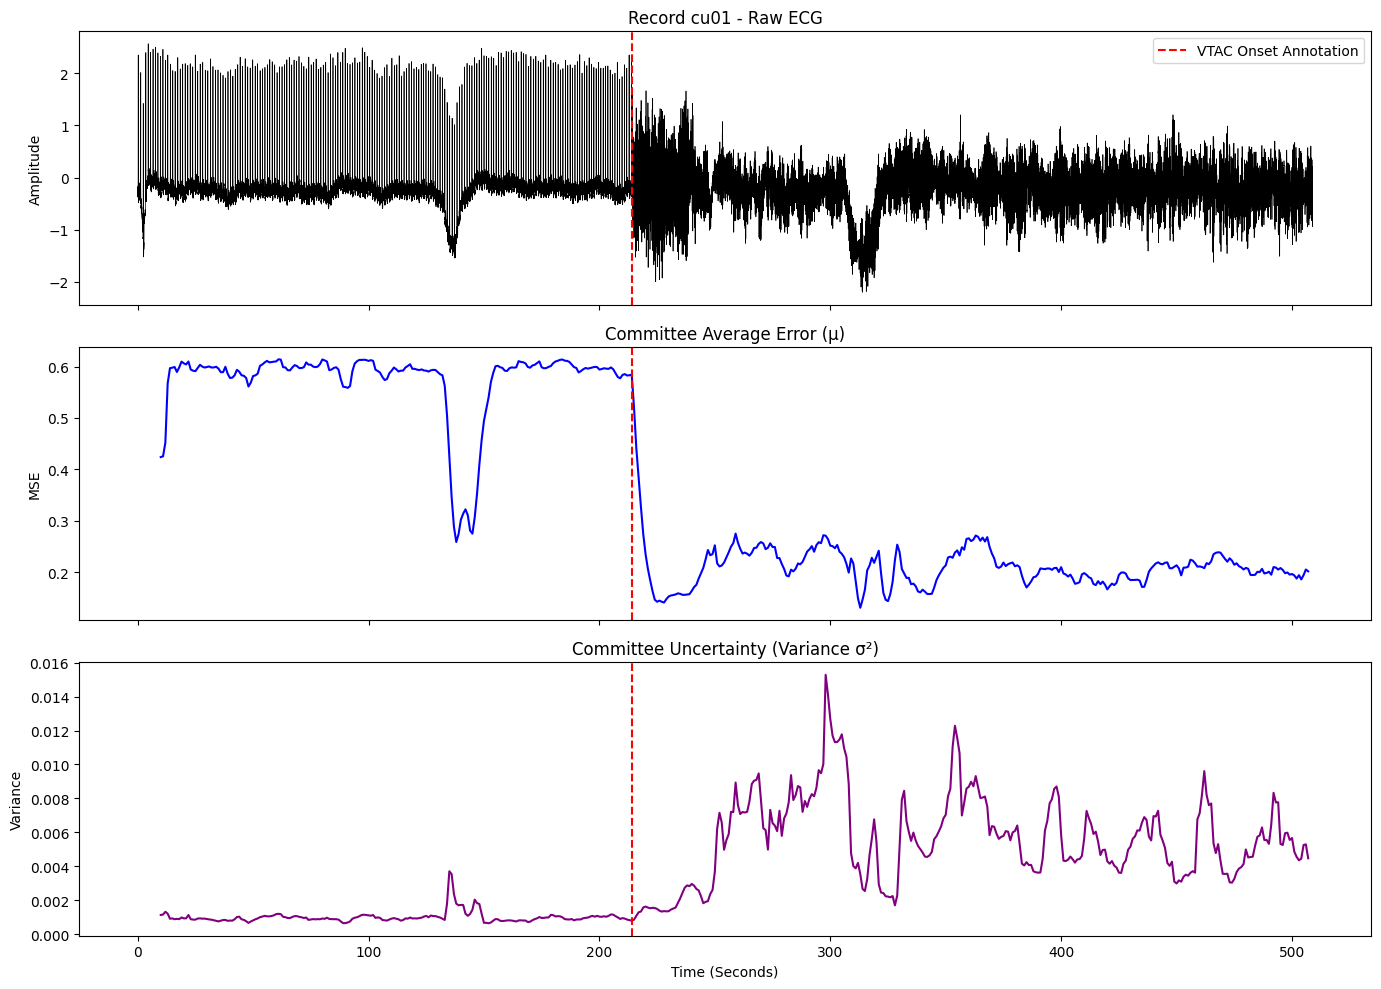

Maximum Variance observed: 0.015279
Average Variance observed: 0.003716


In [10]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_MODELS = 10

CUDB_PATH = "/content/drive/MyDrive/New Research Paper/Data/CUDB"
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Ensemble Models ------------------
ensemble_models = []
print("Loading 10-model Deep Ensemble for Diagnosis...")
for m in range(1, NUM_MODELS + 1):
    model = LSTMAutoencoder().to(DEVICE)
    model_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
        model.eval()
        ensemble_models.append(model)

def get_ensemble_prediction(window):
    mu_window = np.mean(window)
    std_window = np.std(window)
    if std_window > 0:
        norm_window = (window - mu_window) / std_window
    else:
        norm_window = window - mu_window

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)

        mses = []
        for model in ensemble_models:
            recon = model(x)
            mse = ((recon.squeeze() - x.squeeze()) ** 2).mean().item()
            mses.append(mse)

        mses_array = np.array(mses)
        return np.mean(mses_array), np.var(mses_array)

# ------------------ Run cu01 Diagnosis ------------------
rec_name = "cu01"
print(f"Analyzing {rec_name}...")

record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
ecg = record.p_signal[:, 0]
ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')

vtac_annot_sec = None
for sym, samp in zip(ann.symbol, ann.sample):
    if sym == '[' and vtac_annot_sec is None:
        vtac_annot_sec = samp // FS

n_samples = len(ecg)
n_seconds = n_samples // FS

times = []
mean_errors = []
variances = []

for sec in range(SEQ_LEN_SEC, n_seconds):
    start = (sec - SEQ_LEN_SEC) * FS
    end = start + SEQ_LEN
    if end > n_samples: break

    window = ecg[start:end].astype(np.float32)
    if np.std(window) < 0.001:
        mean_errors.append(0.0)
        variances.append(0.0)
    else:
        mean_mse, variance = get_ensemble_prediction(window)
        mean_errors.append(mean_mse)
        variances.append(variance)
    times.append(sec)

# ------------------ Plotting ------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# 1. Raw ECG
ecg_time = np.arange(len(ecg)) / FS
ax1.plot(ecg_time, ecg, color='black', linewidth=0.5)
if vtac_annot_sec:
    ax1.axvline(x=vtac_annot_sec, color='red', linestyle='--', label='VTAC Onset Annotation')
ax1.set_title(f"Record {rec_name} - Raw ECG")
ax1.set_ylabel("Amplitude")
ax1.legend()

# 2. Mean MSE
ax2.plot(times, mean_errors, color='blue')
if vtac_annot_sec:
    ax2.axvline(x=vtac_annot_sec, color='red', linestyle='--')
ax2.set_title("Committee Average Error (\u03bc)")
ax2.set_ylabel("MSE")

# 3. Uncertainty Variance
ax3.plot(times, variances, color='purple')
if vtac_annot_sec:
    ax3.axvline(x=vtac_annot_sec, color='red', linestyle='--')
ax3.set_title("Committee Uncertainty (Variance \u03c3\u00b2)")
ax3.set_xlabel("Time (Seconds)")
ax3.set_ylabel("Variance")

plt.tight_layout()
plt.show()

print(f"Maximum Variance observed: {max(variances):.6f}")
print(f"Average Variance observed: {np.mean(variances):.6f}")

full test

In [ ]:
import wfdb
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------ Configuration ------------------
FS = 250
SEQ_LEN_SEC = 10
SEQ_LEN = SEQ_LEN_SEC * FS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_MODELS = 10

CUDB_PATH = "/content/drive/MyDrive/New Research Paper/Data/CUDB"
MODEL_DIR = "/content/drive/MyDrive/New Research Paper/Models/Ensemble/"

# ------------------ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2):
        super().__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)

    def forward(self, x):
        enc_out, _ = self.encoder(x)
        dec_out, _ = self.decoder(enc_out)
        return dec_out

# ------------------ Load Ensemble Models ------------------
ensemble_models = []
print("Loading 10-model Deep Ensemble for Diagnosis...")
for m in range(1, NUM_MODELS + 1):
    model = LSTMAutoencoder().to(DEVICE)
    model_path = os.path.join(MODEL_DIR, f"LSTM_Ensemble_{m}.pth")
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
        model.eval()
        ensemble_models.append(model)

def get_ensemble_prediction(window):
    mu_window = np.mean(window)
    std_window = np.std(window)
    if std_window > 0:
        norm_window = (window - mu_window) / std_window
    else:
        norm_window = window - mu_window

    with torch.no_grad():
        x = torch.tensor(norm_window, dtype=torch.float32, device=DEVICE)
        x = x.unsqueeze(0).unsqueeze(-1)

        mses = []
        for model in ensemble_models:
            recon = model(x)
            mse = ((recon.squeeze() - x.squeeze()) ** 2).mean().item()
            mses.append(mse)

        mses_array = np.array(mses)
        return np.mean(mses_array), np.var(mses_array)

# ------------------ Run Batch Diagnosis ------------------
for idx in range(1, 36):
    rec_name = f"cu{idx:02d}"
    print(f"\n==================================================")
    print(f"Analyzing {rec_name}...")
    print(f"==================================================")

    try:
        record = wfdb.rdrecord(os.path.join(CUDB_PATH, rec_name))
        ecg = record.p_signal[:, 0]
        ann = wfdb.rdann(os.path.join(CUDB_PATH, rec_name), 'atr')
    except Exception as e:
        print(f"Failed to load {rec_name}: {e}")
        continue

    vtac_annot_sec = None
    for sym, samp in zip(ann.symbol, ann.sample):
        if sym == '[' and vtac_annot_sec is None:
            vtac_annot_sec = samp // FS

    n_samples = len(ecg)
    n_seconds = n_samples // FS

    times = []
    mean_errors = []
    variances = []

    for sec in range(SEQ_LEN_SEC, n_seconds):
        start = (sec - SEQ_LEN_SEC) * FS
        end = start + SEQ_LEN
        if end > n_samples: break

        window = ecg[start:end].astype(np.float32)
        if np.std(window) < 0.001:
            mean_errors.append(0.0)
            variances.append(0.0)
        else:
            mean_mse, variance = get_ensemble_prediction(window)
            mean_errors.append(mean_mse)
            variances.append(variance)
        times.append(sec)

    # ------------------ Plotting ------------------
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # 1. Raw ECG
    ecg_time = np.arange(len(ecg)) / FS
    ax1.plot(ecg_time, ecg, color='black', linewidth=0.5, label='Raw ECG')
    if vtac_annot_sec:
        ax1.axvline(x=vtac_annot_sec, color='red', linestyle='--', label='VTAC Onset Annotation')
    ax1.set_title(f"Record {rec_name} - Raw ECG")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc='upper right')

    # 2. Mean MSE
    ax2.plot(times, mean_errors, color='blue')
    if vtac_annot_sec:
        ax2.axvline(x=vtac_annot_sec, color='red', linestyle='--')
    ax2.set_title("Committee Average Error (\u03bc)")
    ax2.set_ylabel("MSE")

    # 3. Uncertainty Variance
    ax3.plot(times, variances, color='purple')
    if vtac_annot_sec:
        ax3.axvline(x=vtac_annot_sec, color='red', linestyle='--')
    ax3.set_title("Committee Uncertainty (Variance \u03c3\u00b2)")
    ax3.set_xlabel("Time (Seconds)")
    ax3.set_ylabel("Variance")

    plt.tight_layout()
    plt.show()

    if len(variances) > 0:
        print(f"Maximum Variance observed: {max(variances):.6f}")
        print(f"Average Variance observed: {np.mean(variances):.6f}")
    else:
        print("No valid variance data to display for this record.")

Loading 10-model Deep Ensemble for Diagnosis...

Analyzing cu01...
